In [18]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [4]:
pip install darts datatable --upgrade

  Using cached darts-0.16.0-py3-none-any.whl (326 kB)
     |████████████████████████████████| 96.9 MB 112 kB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 11.2 MB 24.4 MB/s 
     |████████████████████████████████| 9.8 MB 40.3 MB/s 
     |████████████████████████████████| 165 kB 40.7 MB/s 
     |████████████████████████████████| 792 kB 62.0 MB/s 
     |████████████████████████████████| 1.4 MB 57.4 MB/s 
     |████████████████████████████████| 374 kB 55.8 MB/s 
     |████████████████████████████████| 890 kB 41.9 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6638209 sha256=cfe768fa7147bfc0df0411a92470d0da75dfd4f28ee041d82a9a9e6013eeee48
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: s

In [5]:
!pip uninstall matplotlib -y
!pip install matplotlib

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import time
from tqdm import tqdm
import pandas as pd
import datatable as dt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)

import seaborn as sns

from datetime import datetime, timedelta
from time import time
from functools import reduce
import itertools
from random import sample
import torch

from sklearn.linear_model import Ridge


from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import (
    TFTModel,
    NaiveSeasonal,
    NaiveDrift,
    RegressionModel
)

from darts.metrics import mape, mase, mae
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

# Global Variables

In [2]:
N_WEEKS_SUM = 3
DEPTH_DATA_WEEKS = 53
LEN_FORECAST_WEEKLY = 3

DEPTH_DATA_DAILY = 366
N_DAYS_SUM = 21
LEN_FORECAST_DAILY = 21

SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/data/'

# Load

In [3]:
df = dt.fread(SAVE_PATH + 'data_2015_2021_filled_base_smooth.csv').to_pandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5181217 entries, 0 to 5181216
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   articul          int32         
 1   date             datetime64[ns]
 2   qty              float64       
 3   qty_base_smooth  float64       
 4   orders           int32         
 5   rubr_lev1        object        
 6   root_rubric      object        
dtypes: datetime64[ns](1), float64(2), int32(2), object(2)
memory usage: 237.2+ MB


In [4]:
rubric_dict = df.groupby('articul')['root_rubric', 'rubr_lev1'].max()
rubric_dict

,root_rubric,rubr_lev1
articul,,
199,Инструмент,Перфораторы
205,Инструмент,Перфораторы
206,Инструмент,Перфораторы
209,Инструмент,Перфораторы
604,Все для сада,Триммеры
...,...,...
18241711,Электрика и свет,Кабель и провод
18241771,Электрика и свет,Кабель и провод
18241807,Электрика и свет,Кабель и провод


In [5]:
rubrics = rubric_dict['rubr_lev1'].unique().tolist()

# Weekly data

In [6]:
df_weekly = df.set_index('date').groupby(['articul'])['qty_base_smooth', 'orders'].resample('W').sum().reset_index()
df_weekly

,articul,date,qty_base_smooth,orders
0,199,2015-08-09,4.0,2
1,199,2015-08-16,5.0,1
2,199,2015-08-23,1.0,1
3,199,2015-08-30,5.0,3
4,199,2015-09-06,2.0,1
...,...,...,...,...
744555,18317623,2021-09-05,3.0,3
744556,18317623,2021-09-12,0.0,0
744557,18317623,2021-09-19,1.0,1
744558,18317623,2021-09-26,1.0,1


In [7]:
len(df_weekly['articul'].unique())

5482

## Normed Rubric Reps

In [8]:
sum_normed_dict = {}
sum_normed_sc_dict = {}
sum_normed_sc_train = {}
sum_normed_sc_test = {}
for rubric in rubrics:
    rubric_sum_normed = df_weekly.join(rubric_dict, on='articul').query('rubr_lev1 == @rubric')\
    .groupby('date')['qty_base_smooth'].agg([sum, lambda x: np.log1p(np.sum(x>0))])\
    .assign(sum_normed = lambda x: x.iloc[:,0]/x.iloc[:,1])['sum_normed']
    
    ts = TimeSeries.from_series(rubric_sum_normed.clip(lower=1), fill_missing_dates=True, fillna_value=1, freq='W')
  
    sum_normed_dict[rubric] = ts
    
sum_normed_dict;


# Regression Model

<a name="good_art"></a>
## Хорошие товары 




In [9]:
def goodify(df:pd.DataFrame=df_weekly, end_date='2021-09-12', sales_period_weeks = 4, min_oders_count=2, 
            data_depth= 3 + LEN_FORECAST_WEEKLY) -> (pd.DataFrame, list):
    '''
    Good data consists of articuls from 'df', for which there are some orders in the last 'sales_period_weeks' weeks.
    The min order count is determined by 'min_orders_count'.
    
    Returns df with only good data and list of good articuls.
    
    
    '''
    last_date = pd.Timestamp(end_date)
    first_date = last_date - timedelta(weeks=sales_period_weeks)
    last_dates_data = df.query('@first_date<=date<=@last_date')
    
    art_order_count = last_dates_data.groupby('articul')['orders'].sum()
    good_arts = art_order_count[art_order_count >= min_oders_count].index
    
    df_good = df.query('articul in @good_arts')

    last_forecast_date = last_date + timedelta(weeks = LEN_FORECAST_WEEKLY)

    df_good = df_good.query('date <= @last_forecast_date')

    data_length_art = df_good.groupby('articul')['date'].agg([min, max])
    year_long_arts = data_length_art[data_length_art['max'] - data_length_art['min'] >= timedelta(weeks=data_depth)].index                   
    df_good = df_good.query('articul in @year_long_arts') 
    
    return(df_good, year_long_arts)

goodify(df_weekly, '2021-07-04');

## Actual TimeSeries

In [10]:
ts_act_dict = {}
for art in rubric_dict.index:
    ts_act_dict[art] = TimeSeries.from_series(df_weekly.query('articul == @art').set_index('date')['qty_base_smooth'], freq='W')


In [11]:
len(ts_act_dict)

5482

## Individual models on each series with normed rubric sum covariates calculated based on "good" series with or without seasonal covariates


В этой секции пытаемся использовать нормированные суммы по рубрике, как прошлые ковариаты, а также тюнить лаги по ним, используя бэктестинг за год.

#### Normed Sums Sample

In [12]:
def normed_sum_sample(art_sample, date):
    
    sum_normed = df_weekly.query('articul in @art_sample')\
      .groupby('date')['qty_base_smooth'].agg([sum, lambda x: np.log1p(np.sum(x>0))])\
      .assign(sum_normed = lambda x: x.iloc[:,0]/x.iloc[:,1])['sum_normed']
    
    ts = TimeSeries.from_series(sum_normed, fill_missing_dates=True, fillna_value=0, freq='W')

    train, val = ts.split_after(pd.Timestamp(date))
  
    scaler = Scaler()
    train = scaler.fit_transform(train)
    ts_sc = scaler.transform(ts)

    return train, ts_sc

### Scale, covariates and split

In [13]:
def scale_split_cov(art_sample, date='20210912'):
    scaler_dict = {}
    covs_dict = {}
    ts_train_dict = {}
    ts_val_dict = {}

    covs_train_dict = {}
    covs_val_dict = {}
        
    for art in art_sample:
        ts_act = ts_act_dict[art]
        train_act, val_act = ts_act.split_after(pd.Timestamp(date))
        
        scaler = Scaler()
        train = scaler.fit_transform(train_act)
        val = scaler.transform(val_act)
        scaler_dict[art] = scaler
        ts_train_dict[art] = train
        ts_val_dict[art] = val

        covariates = datetime_attribute_timeseries(ts_act, attribute='year', one_hot=False)
        covariates = covariates.stack(datetime_attribute_timeseries(ts_act, attribute='month', one_hot=False))
        covariates = covariates.stack(TimeSeries.from_times_and_values(times=ts_act.time_index, values=np.arange(len(ts_act)), columns=['linear_increase']))
        covariates = covariates.add_holidays(country_code="RU")
        
        covariates = covariates.astype(np.float32)
        
        train_covs, val_covs = covariates.split_after(pd.Timestamp(date))

        scaler_covs = Scaler()
        scaler_covs.fit(train_covs)
        covariates = scaler_covs.transform(covariates)
        covs_dict[art] = covariates
        covs_val_dict[art] = val
        covs_train_dict[art] = train
        
    return ts_train_dict, ts_val_dict, covs_dict, covs_val_dict, covs_train_dict, scaler_dict

scale_split_cov(rubric_dict.index[:5]);

### Функция прогноза одного артикула на заданную дату

In [14]:
lags_ls = [[-1, -2, -3],
           [-51, -52, -53],
           [-103, -104, -105],
           [-155, -156, -157]
    ]

    
lags_ls_samples = [lags_ls[0], 
                   lags_ls[0] + lags_ls[1], 
                   lags_ls[0] + lags_ls[1] + lags_ls[2], 
                   lags_ls[0] + lags_ls[1] + lags_ls[2] + lags_ls[3], 
                   lags_ls[0] + lags_ls[2] + lags_ls[3], 
                   lags_ls[0] + lags_ls[1] + lags_ls[3],
                  lags_ls[0] + lags_ls[1] + lags_ls[2]]
lags_ls_samples

[[-1, -2, -3],
 [-1, -2, -3, -51, -52, -53],
 [-1, -2, -3, -51, -52, -53, -103, -104, -105],
 [-1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157],
 [-1, -2, -3, -103, -104, -105, -155, -156, -157],
 [-1, -2, -3, -51, -52, -53, -155, -156, -157],
 [-1, -2, -3, -51, -52, -53, -103, -104, -105]]

In [15]:
lag_ls_2_year = lags_ls_samples[0:3] + [lags_ls_samples[6]]
lag_ls_2_year

[[-1, -2, -3],
 [-1, -2, -3, -51, -52, -53],
 [-1, -2, -3, -51, -52, -53, -103, -104, -105],
 [-1, -2, -3, -51, -52, -53, -103, -104, -105]]

In [16]:
lag_ls_1_year = lags_ls_samples[0:2]
lag_ls_1_year

[[-1, -2, -3], [-1, -2, -3, -51, -52, -53]]

In [17]:
lags_ls_samples_zero =[[0]] + [[0, -1]] + [[0] + ls for ls in lags_ls_samples]
lags_ls_samples_zero

[[0],
 [0, -1],
 [0, -1, -2, -3],
 [0, -1, -2, -3, -51, -52, -53],
 [0, -1, -2, -3, -51, -52, -53, -103, -104, -105],
 [0, -1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157],
 [0, -1, -2, -3, -103, -104, -105, -155, -156, -157],
 [0, -1, -2, -3, -51, -52, -53, -155, -156, -157],
 [0, -1, -2, -3, -51, -52, -53, -103, -104, -105]]

In [18]:
def errors_reg_date_sample(art_ls:list, 
                           date:str, 
                           lags:list, 
                           lags_future_covariates:list,
                           future_covariates:bool=True,  
                           past_covariates:bool=True,
                           backtest_depth_weeks:int = 7) -> pd.DataFrame:

    df_sample = df_weekly.query('articul in @art_ls')

    
    df_sample, art_ls = goodify(df_sample, date)

    print(f'Using {len(art_ls)} articuls')
    
    ts_train_dict, ts_val_dict, covs_dict, covs_val_dict, covs_train_dict,\
    scaler_dict = scale_split_cov(art_ls, date=date)
    
    
    if past_covariates:
        train_past_cov, past_cov = normed_sum_sample(art_ls, date)
    else:
        past_covs_ls = None
        past_train_covs_ls = None
        lags_past_covariates = None

    if not future_covariates:    
        lags_future_covariates=None
        cov_ls=None

    date_start = pd.Timestamp(date) - timedelta(weeks=backtest_depth_weeks)

    error_dict= {}

    for art in tqdm(art_ls):
      

      ts_train = ts_train_dict[art]

      def lag_tune_backtest(ts=ts_train, lags = lags):
        error_min = np.inf
        for lag in lags:
            for use_future_covs in [False, True]:
              if use_future_covs:
                lag_cov = lags_future_covariates
                future_cov = covs_dict[art]
              else:
                lag_cov = None
                future_cov = None  
              model = RegressionModel(lags=lag, 
                                      lags_future_covariates=lag_cov,
                                      lags_past_covariates=lag,
                                      model=Ridge(alpha=1))
              
              try:
                error = model.backtest(ts, 
                                        future_covariates=future_cov,
                                        past_covariates=train_past_cov,
                                        start=date_start, 
                                        stride=1, 
                                        forecast_horizon=3, 
                                        metric=mae)
              except ValueError:
                continue  
              if error < error_min:
                  error_min = error
                  best_use_covs = use_future_covs
                  best_lag = lag
                  #best_past_lag = past_lag
        return best_use_covs, best_lag

      if len(ts_train) >= 157 + backtest_depth_weeks:
        #print('3 year')
        lag_sample = lags
        best_use_covs, best_lag = lag_tune_backtest(lags=lag_sample)

      elif len(ts_train) >= 105 + backtest_depth_weeks:
        #print('2 year')
        lag_sample = lag_ls_2_year
        best_use_covs, best_lag = lag_tune_backtest(lags=lag_sample)

      elif len(ts_train) >= 53 + backtest_depth_weeks:
        #print('1 year')
        lag_sample = lag_ls_1_year
        best_use_covs, best_lag = lag_tune_backtest(lags=lag_sample)

      else:
        #print('short')
        best_use_covs = False
        best_lag = [-1, -2, -3]  

      '''          
      print('\n')
      print(f'Best lag is {best_lag}')
      #print(f'Best past covariate lag is {best_past_lag}')
      print(f'Use future covariates is {best_use_covs}') 
      print(f'Error min is {error_min}')
      '''
                  #val_series=ts_val_list,
                  #val_past_covariates=month_val_list)

      if not best_use_covs:
        future_cov = None
        lag_covs = None
      else:
        future_cov = covs_dict[art]
        lag_covs = lags_future_covariates            

      reg_model = RegressionModel(lags=best_lag, 
                                  lags_future_covariates=lag_covs,
                                  lags_past_covariates=best_lag,
                                  model=Ridge(alpha=1))

      
      
      reg_model.fit(series = ts_train_dict[art],
                    past_covariates = train_past_cov,
                    future_covariates = future_cov)  
         
             
      predict_reg = reg_model.predict(3,
                                      series = ts_train_dict[art],
                                      past_covariates = past_cov,
                                      future_covariates = future_cov)   

      predict_base_sum = ts_train_dict[art][-3:].sum()
      predict_reg_sum = predict_reg.sum()
      actual_sum = ts_val_dict[art][:3].sum()

      reg_error = abs(actual_sum - predict_reg_sum).iloc[0]

      base_error = abs(actual_sum - predict_base_sum).iloc[0]
      error_dict[art] = [reg_error, base_error]
    error_frame = pd.DataFrame.from_dict(error_dict, orient='index', columns=['error_reg', 'error_base'])
    print('\n')
    print(f'Found predictions for {len(error_frame)} articuls')
    return error_frame  

#perf_arts = rubric_dict.query('rubr_lev1 == "Перфораторы"').index
'''
errors_perf = errors_reg_date_sample(perf_arts, "20210905", 
                       lags = lags_ls_samples, 
                       lags_future_covariates=[0],  
                       good=True).abs().median()'''


'\nerrors_perf = errors_reg_date_sample(perf_arts, "20210905", \n                       lags = lags_ls_samples, \n                       lags_future_covariates=[0],  \n                       good=True).abs().median()'

In [19]:
def base_scale_heatmap(df, df_for_means, show_means=True):
    df_base_scale = df.drop(['error_base'], axis=1).div(df['error_base'], axis=0)
    if show_means:
        means = df_for_means.abs().median()
        means = means / means['error_base']
        means = means.drop('error_base')
        means.name = 'Общие средние'
        df_base_scale = df_base_scale.append(means)
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.heatmap(df_base_scale, vmin=0, vmax=1, annot=True, annot_kws={"size": 24})
    plt.title('Средние ошибки в сравнении с базовой моделью', size=24)
    plt.ylabel('')
    plt.yticks(rotation=0, size=24)
    plt.xticks(None)
    plt.xlabel(None)
    plt.show() 
    return(df_base_scale)

def base_error_compare(error, category_list = ['rubr_lev1'], show_means=True, query=None):
    #base_error = base_error.merge(art_rubric_dict, on='articul')
    errors = rubric_dict.join(error, on='articul')
    if query:    
        errors = errors.query(query)
    #display(errors.sort_values(by='error_rbf', ascending=False).head(20))
    MAE_errors = errors.groupby(category_list).apply(lambda x : x[['error_base', 'error_reg']].abs().median())

    base_scale_heatmap(MAE_errors, errors[['error_base', 'error_reg']], show_means=show_means)
    
    

    return (MAE_errors.append(errors[['error_base', 'error_reg']].abs().median().rename('Общие средние')))

In [21]:
errors_ls = []
for rubric in rubrics:
    print(f'{rubric}')
    rubric_arts = rubric_dict.query('rubr_lev1 == @rubric').index.tolist()
    errors_frame_rubric = errors_reg_date_sample(rubric_arts, '2021-09-05', lags_ls_samples, [0])
    errors_ls.append(errors_frame_rubric)

errors_frame = pd.concat(errors_ls) 


Перфораторы
Using 296 articuls


100%|██████████| 296/296 [16:00<00:00,  3.25s/it]




Found predictions for 296 articuls
Триммеры
Using 364 articuls


100%|██████████| 364/364 [15:48<00:00,  2.61s/it]




Found predictions for 364 articuls
Кабель и провод
Using 1056 articuls


100%|██████████| 1056/1056 [17:43<00:00,  1.01s/it]



Found predictions for 1056 articuls


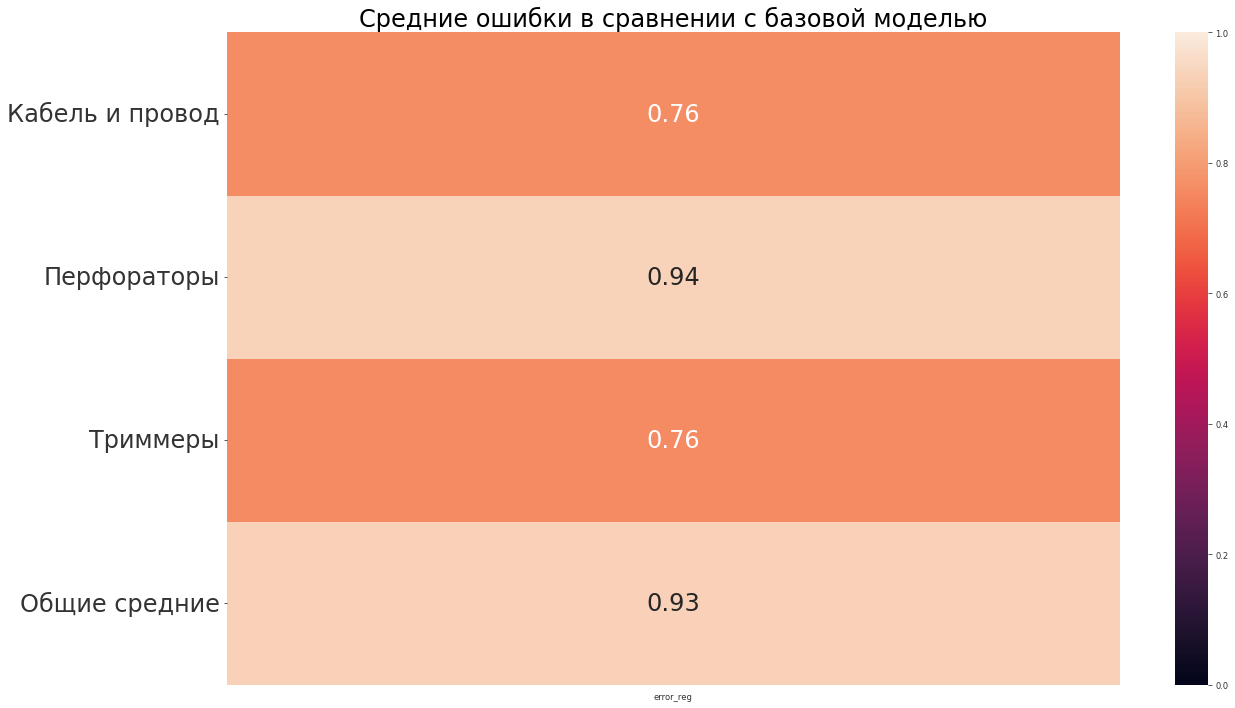

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.500000,0.381699
Перфораторы,0.308036,0.288218
Триммеры,0.201563,0.153442
Общие средние,0.333333,0.310633


In [22]:
base_error_compare(errors_frame)

#### All Months

In [23]:
def base_scale_heatmap(df, df_for_means, show_means=True):
    df_base_scale = df.drop(['error_base'], axis=1).div(df['error_base'], axis=0)
    if show_means:
        means = df_for_means.abs().median()
        means = means / means['error_base']
        means = means.drop('error_base')
        means.name = 'Общие средние'
        df_base_scale = df_base_scale.append(means)
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.heatmap(df_base_scale, vmin=0, vmax=1, annot=True, annot_kws={"size": 24})
    plt.title('Средние ошибки в сравнении с базовой моделью', size=24)
    plt.ylabel('')
    plt.yticks(rotation=0, size=24)
    plt.xticks(None)
    plt.xlabel(None)
    plt.show() 
    return(df_base_scale)

def base_error_compare(error, category_list = ['rubr_lev1'], show_means=True, query=None):
    #base_error = base_error.merge(art_rubric_dict, on='articul')
    errors = rubric_dict.join(error, on='articul')
    if query:    
        errors = errors.query(query)
    #display(errors.sort_values(by='error_rbf', ascending=False).head(20))
    MAE_errors = errors.groupby(category_list).apply(lambda x : x[['error_base', 'error_reg']].abs().median())

    base_scale_heatmap(MAE_errors, errors[['error_base', 'error_reg']], show_means=show_means)
    
    

    return (MAE_errors.append(errors[['error_base', 'error_reg']].abs().median().rename('Общие средние')))

Forecasting 3 weeks after 2020-10-04
Перфораторы
Using 260 articuls


100%|██████████| 260/260 [14:21<00:00,  3.31s/it]




Found predictions for 260 articuls
Триммеры
Using 285 articuls


100%|██████████| 285/285 [13:03<00:00,  2.75s/it]




Found predictions for 285 articuls
Кабель и провод
Using 729 articuls


100%|██████████| 729/729 [11:17<00:00,  1.08it/s]




Found predictions for 729 articuls


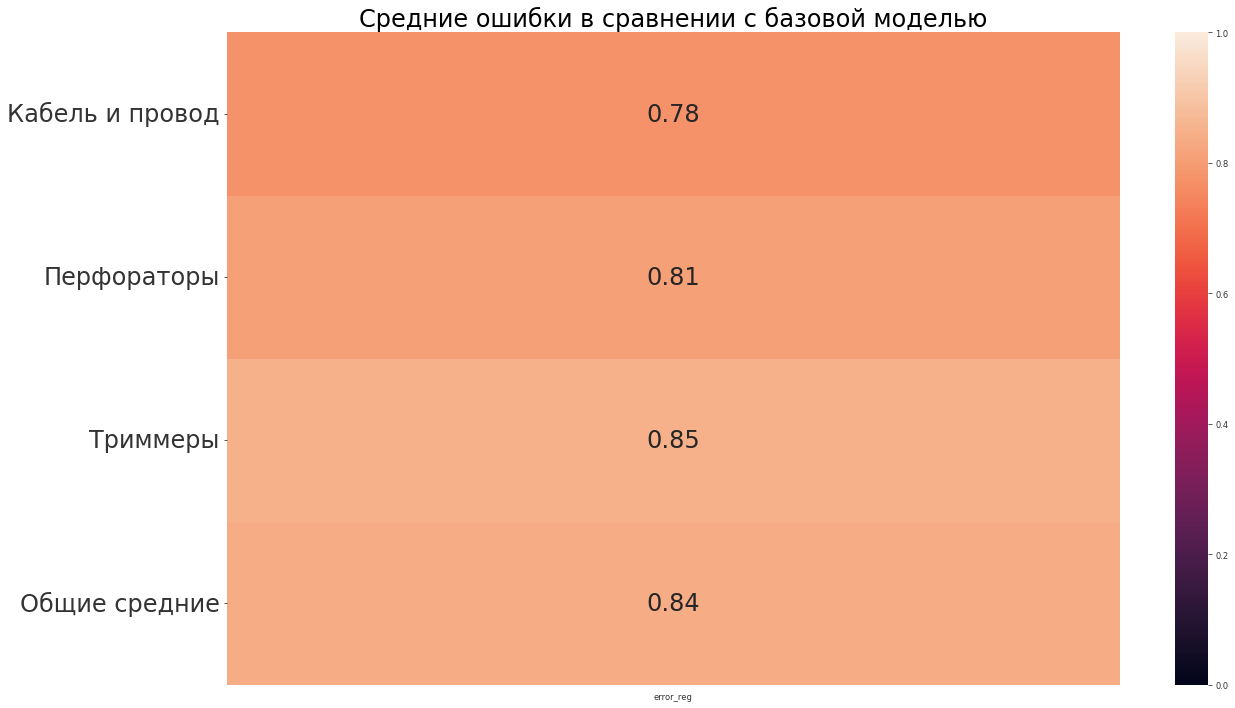

------------------------------------------------------------------------

Forecasting 3 weeks after 2020-11-01
Перфораторы
Using 265 articuls


100%|██████████| 265/265 [14:39<00:00,  3.32s/it]




Found predictions for 265 articuls
Триммеры
Using 228 articuls


100%|██████████| 228/228 [10:47<00:00,  2.84s/it]




Found predictions for 228 articuls
Кабель и провод
Using 749 articuls


100%|██████████| 749/749 [10:56<00:00,  1.14it/s]




Found predictions for 749 articuls


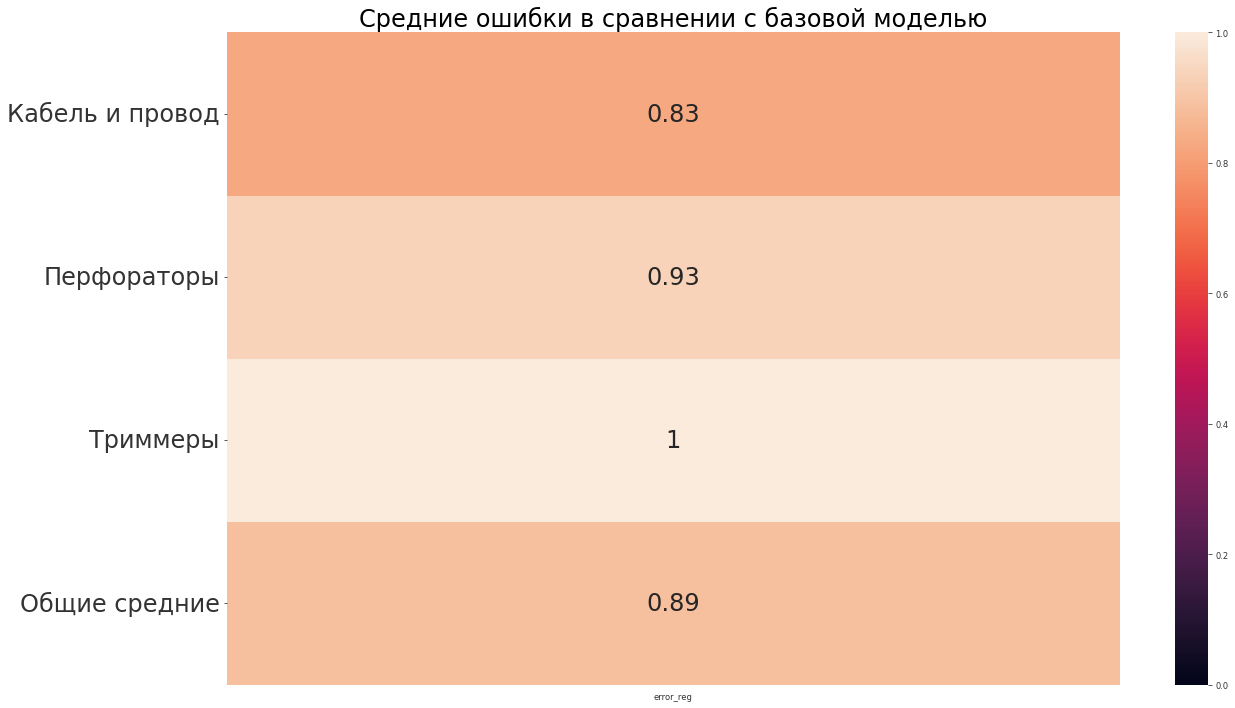

------------------------------------------------------------------------

Forecasting 3 weeks after 2020-11-29
Перфораторы
Using 254 articuls


100%|██████████| 254/254 [14:29<00:00,  3.42s/it]




Found predictions for 254 articuls
Триммеры
Using 170 articuls


100%|██████████| 170/170 [08:33<00:00,  3.02s/it]




Found predictions for 170 articuls
Кабель и провод
Using 817 articuls


100%|██████████| 817/817 [11:20<00:00,  1.20it/s]




Found predictions for 817 articuls


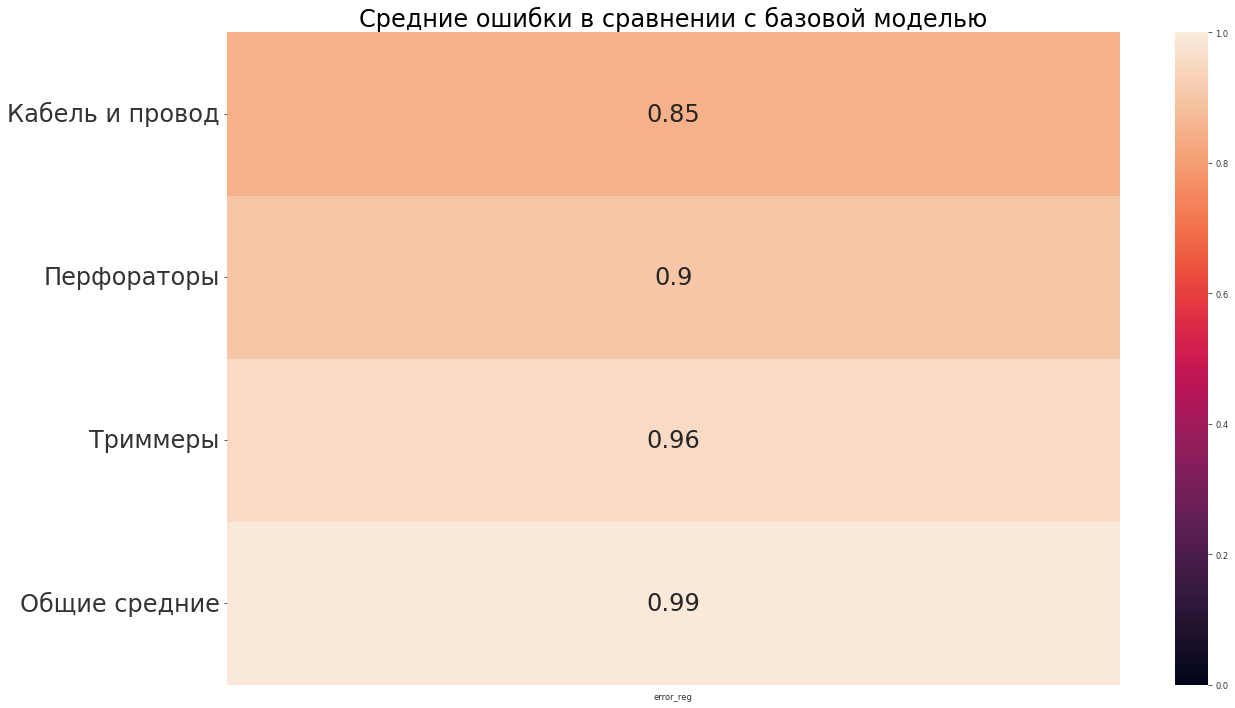

------------------------------------------------------------------------

Forecasting 3 weeks after 2020-12-27
Перфораторы
Using 266 articuls


100%|██████████| 266/266 [14:40<00:00,  3.31s/it]




Found predictions for 266 articuls
Триммеры
Using 178 articuls


100%|██████████| 178/178 [09:01<00:00,  3.04s/it]




Found predictions for 178 articuls
Кабель и провод
Using 847 articuls


100%|██████████| 847/847 [11:03<00:00,  1.28it/s]




Found predictions for 847 articuls


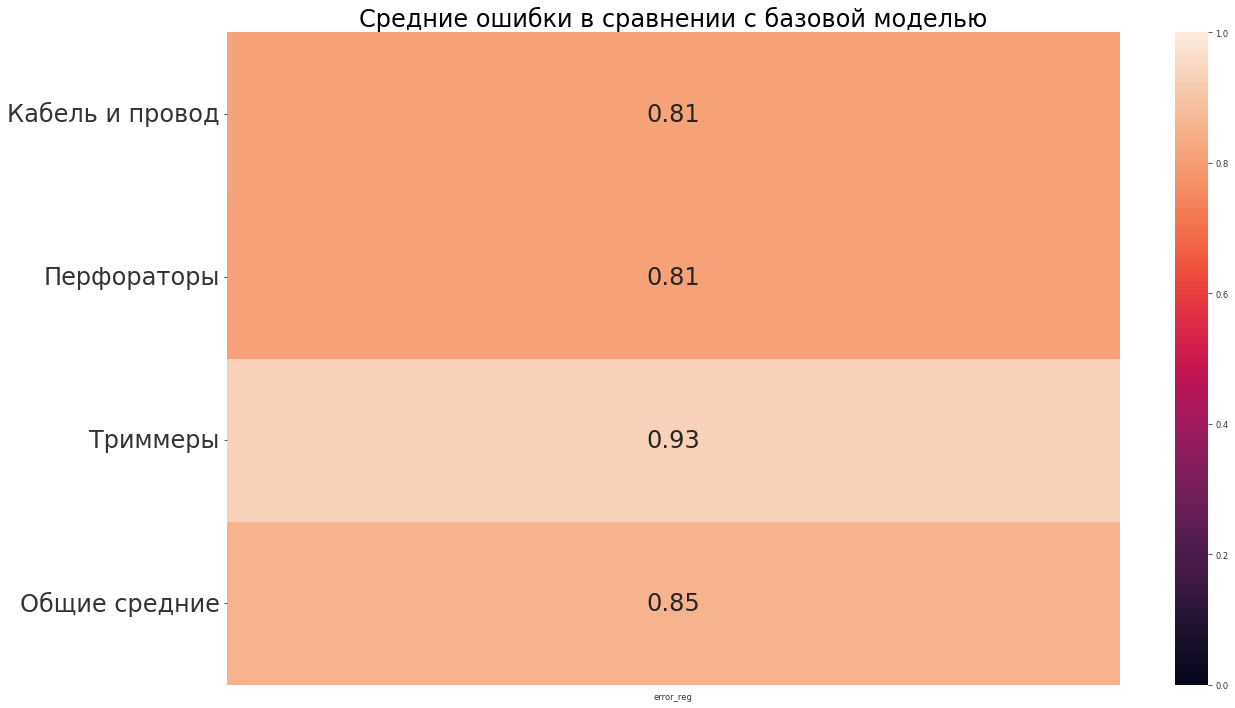

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-01-24
Перфораторы
Using 253 articuls


100%|██████████| 253/253 [14:12<00:00,  3.37s/it]




Found predictions for 253 articuls
Триммеры
Using 167 articuls


100%|██████████| 167/167 [08:09<00:00,  2.93s/it]




Found predictions for 167 articuls
Кабель и провод
Using 742 articuls


100%|██████████| 742/742 [10:33<00:00,  1.17it/s]




Found predictions for 742 articuls


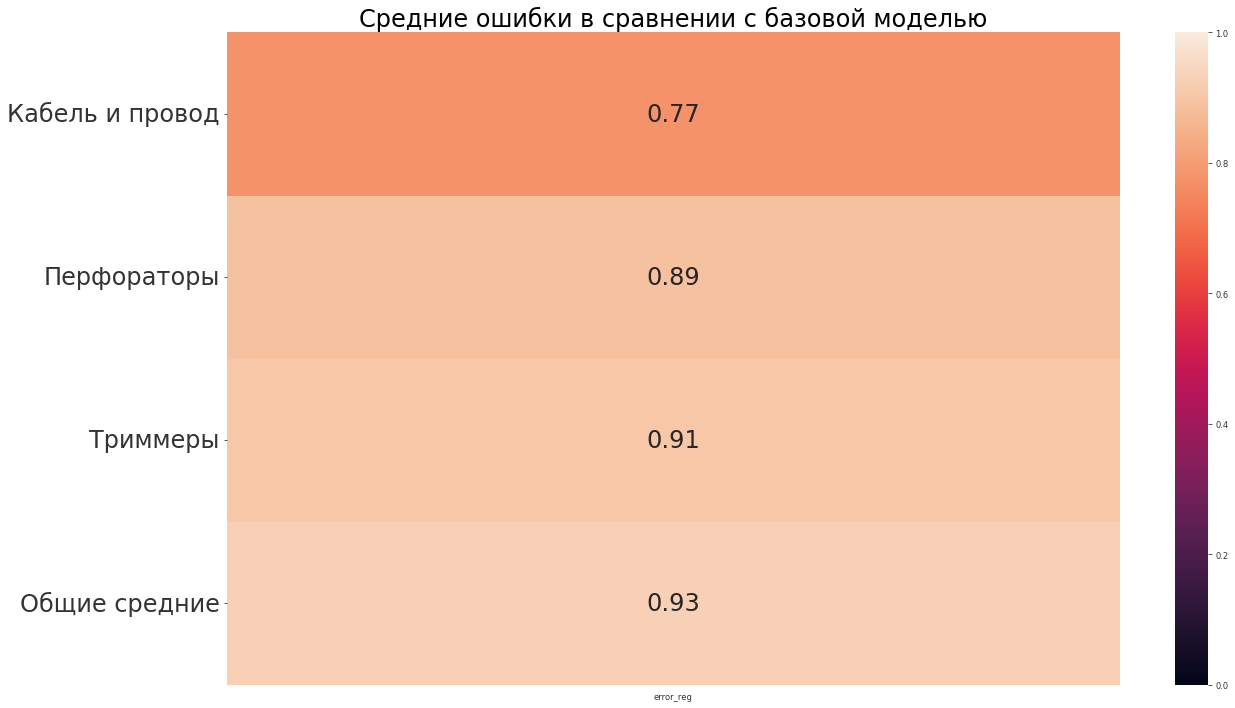

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-02-21
Перфораторы
Using 277 articuls


100%|██████████| 277/277 [15:53<00:00,  3.44s/it]




Found predictions for 277 articuls
Триммеры
Using 200 articuls


100%|██████████| 200/200 [09:48<00:00,  2.94s/it]




Found predictions for 200 articuls
Кабель и провод
Using 862 articuls


100%|██████████| 862/862 [13:35<00:00,  1.06it/s]




Found predictions for 862 articuls


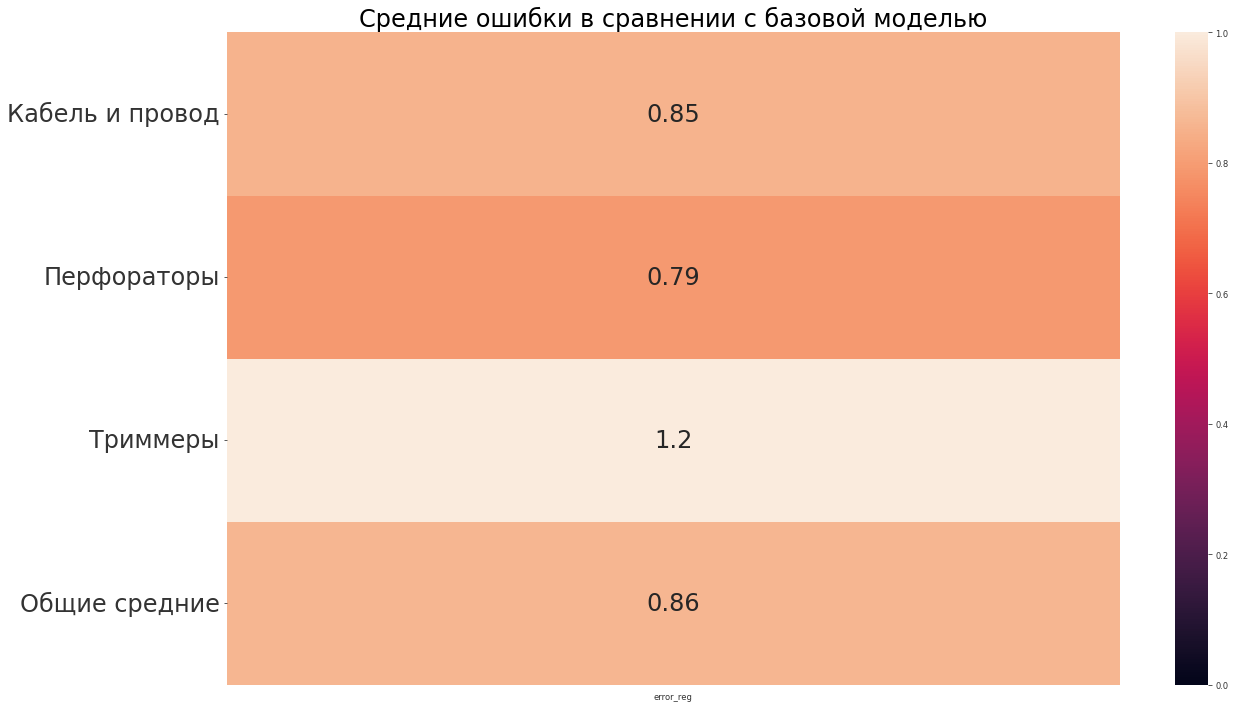

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-03-21
Перфораторы
Using 265 articuls


100%|██████████| 265/265 [15:06<00:00,  3.42s/it]




Found predictions for 265 articuls
Триммеры
Using 216 articuls


100%|██████████| 216/216 [10:53<00:00,  3.02s/it]




Found predictions for 216 articuls
Кабель и провод
Using 956 articuls


100%|██████████| 956/956 [14:45<00:00,  1.08it/s]




Found predictions for 956 articuls


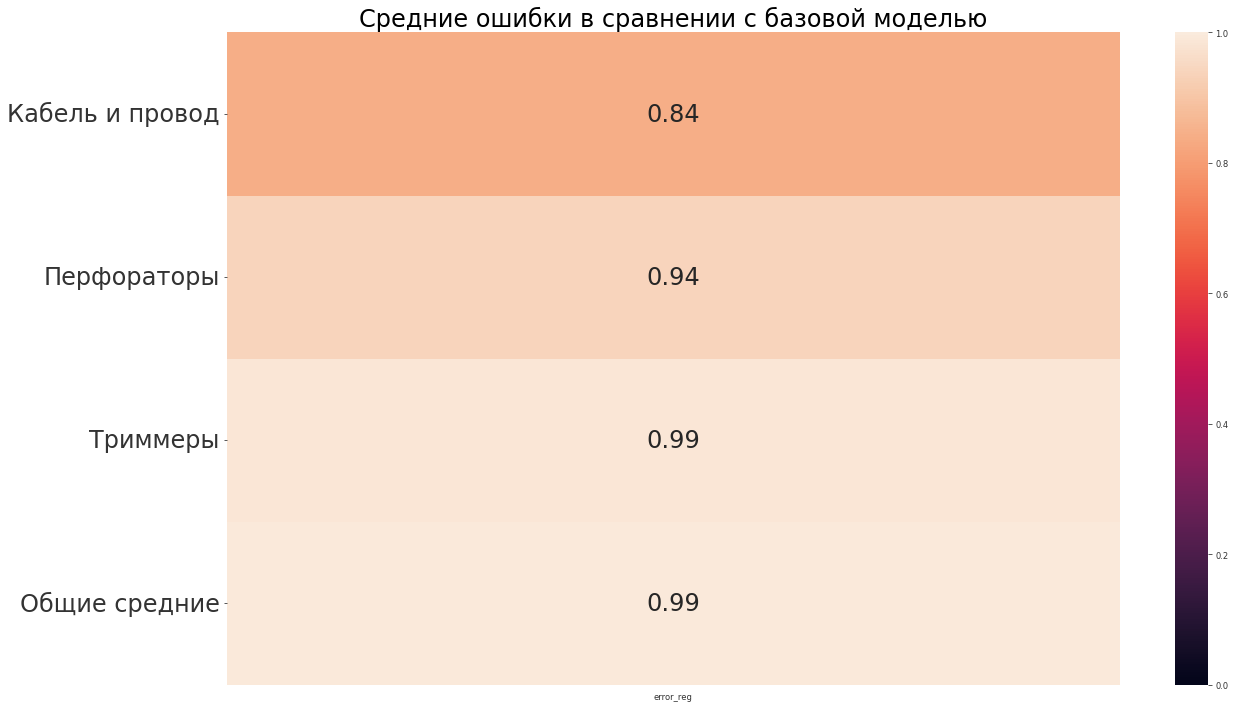

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-04-18
Перфораторы
Using 280 articuls


100%|██████████| 280/280 [15:34<00:00,  3.34s/it]




Found predictions for 280 articuls
Триммеры
Using 242 articuls


100%|██████████| 242/242 [12:00<00:00,  2.98s/it]




Found predictions for 242 articuls
Кабель и провод
Using 1084 articuls


100%|██████████| 1084/1084 [17:13<00:00,  1.05it/s]




Found predictions for 1084 articuls


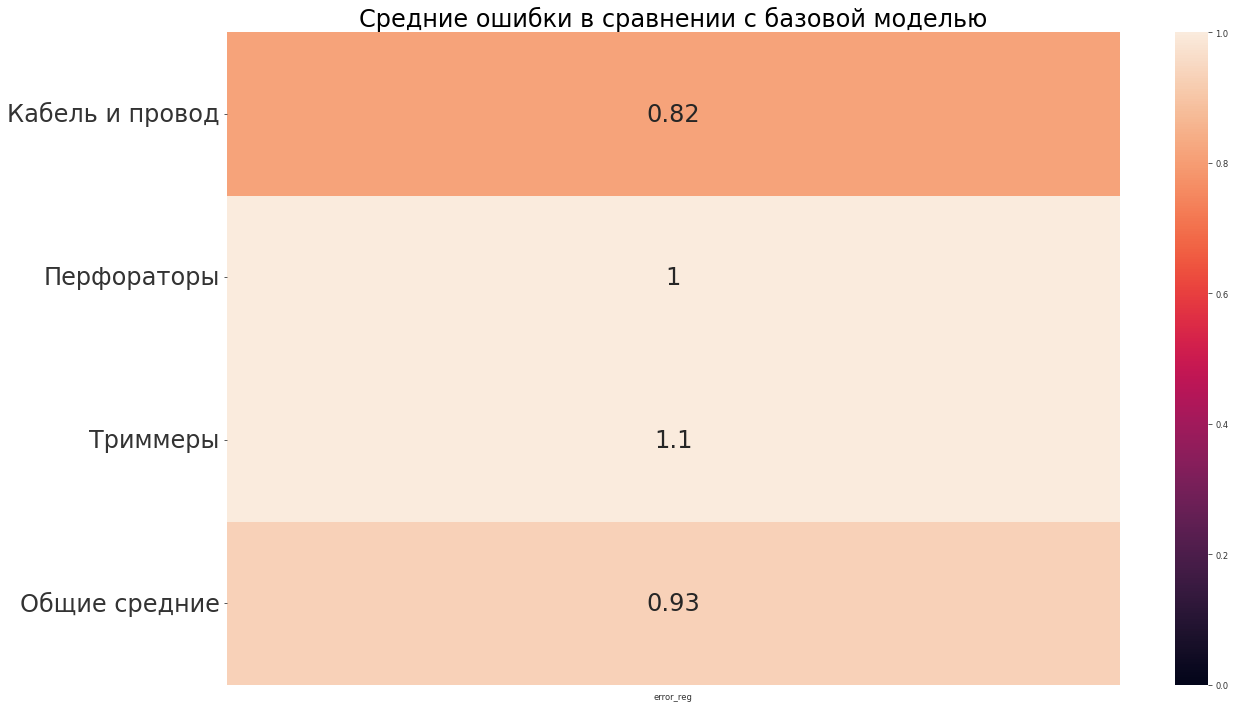

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-05-16
Перфораторы
Using 283 articuls


100%|██████████| 283/283 [15:46<00:00,  3.34s/it]




Found predictions for 283 articuls
Триммеры
Using 308 articuls


100%|██████████| 308/308 [12:58<00:00,  2.53s/it]




Found predictions for 308 articuls
Кабель и провод
Using 1065 articuls


100%|██████████| 1065/1065 [15:54<00:00,  1.12it/s]




Found predictions for 1065 articuls


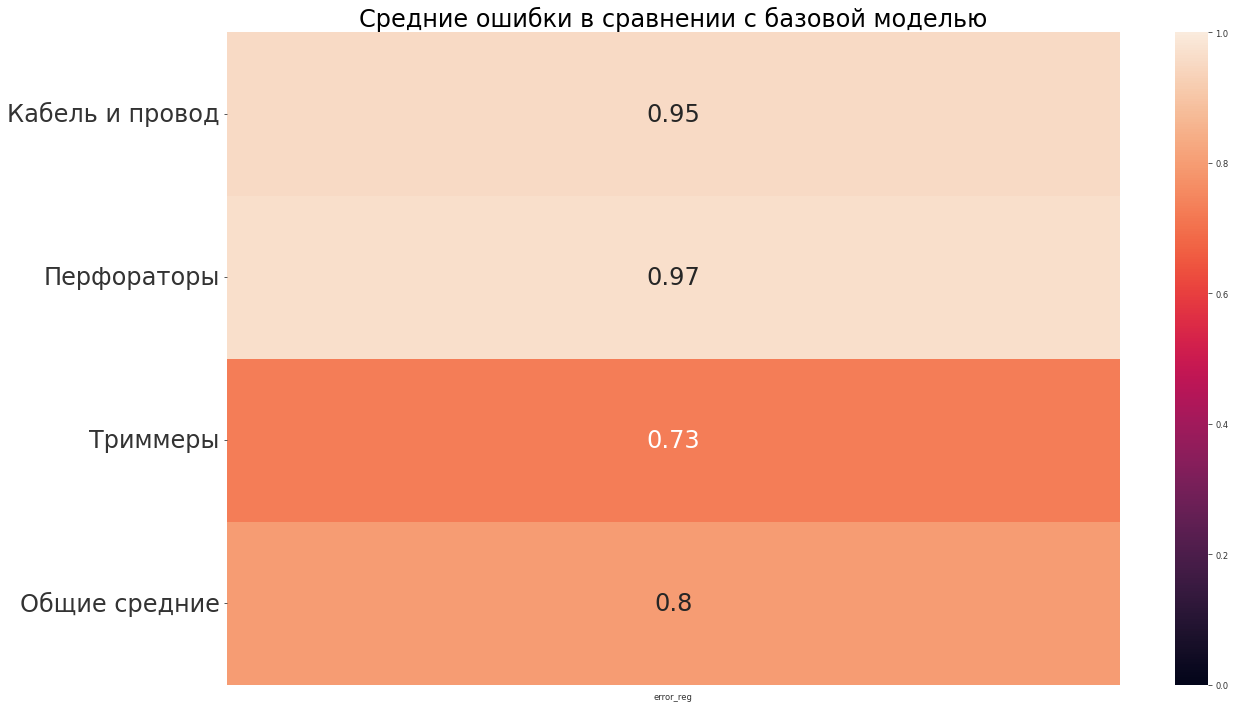

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-06-13
Перфораторы
Using 292 articuls


100%|██████████| 292/292 [15:45<00:00,  3.24s/it]




Found predictions for 292 articuls
Триммеры
Using 393 articuls


100%|██████████| 393/393 [15:22<00:00,  2.35s/it]




Found predictions for 393 articuls
Кабель и провод
Using 1072 articuls


100%|██████████| 1072/1072 [17:23<00:00,  1.03it/s]




Found predictions for 1072 articuls


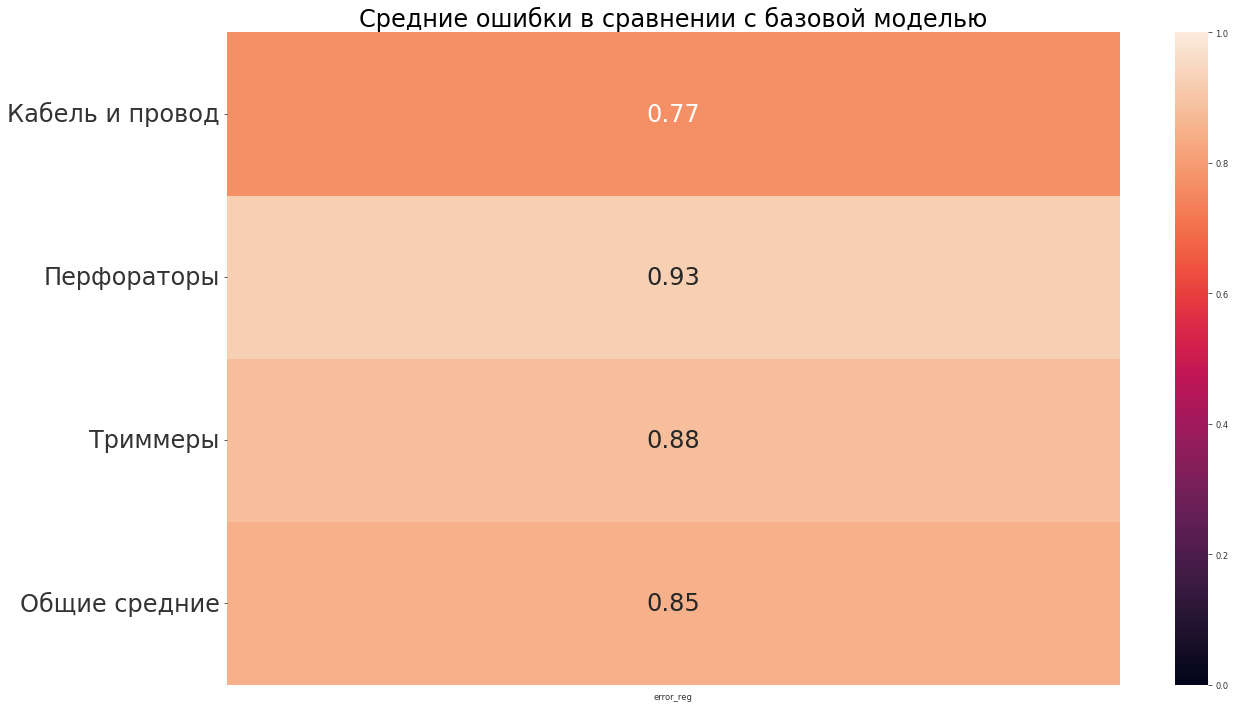

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-07-11
Перфораторы
Using 280 articuls


100%|██████████| 280/280 [14:53<00:00,  3.19s/it]




Found predictions for 280 articuls
Триммеры
Using 409 articuls


100%|██████████| 409/409 [15:46<00:00,  2.32s/it]




Found predictions for 409 articuls
Кабель и провод
Using 1003 articuls


100%|██████████| 1003/1003 [16:53<00:00,  1.01s/it]




Found predictions for 1003 articuls


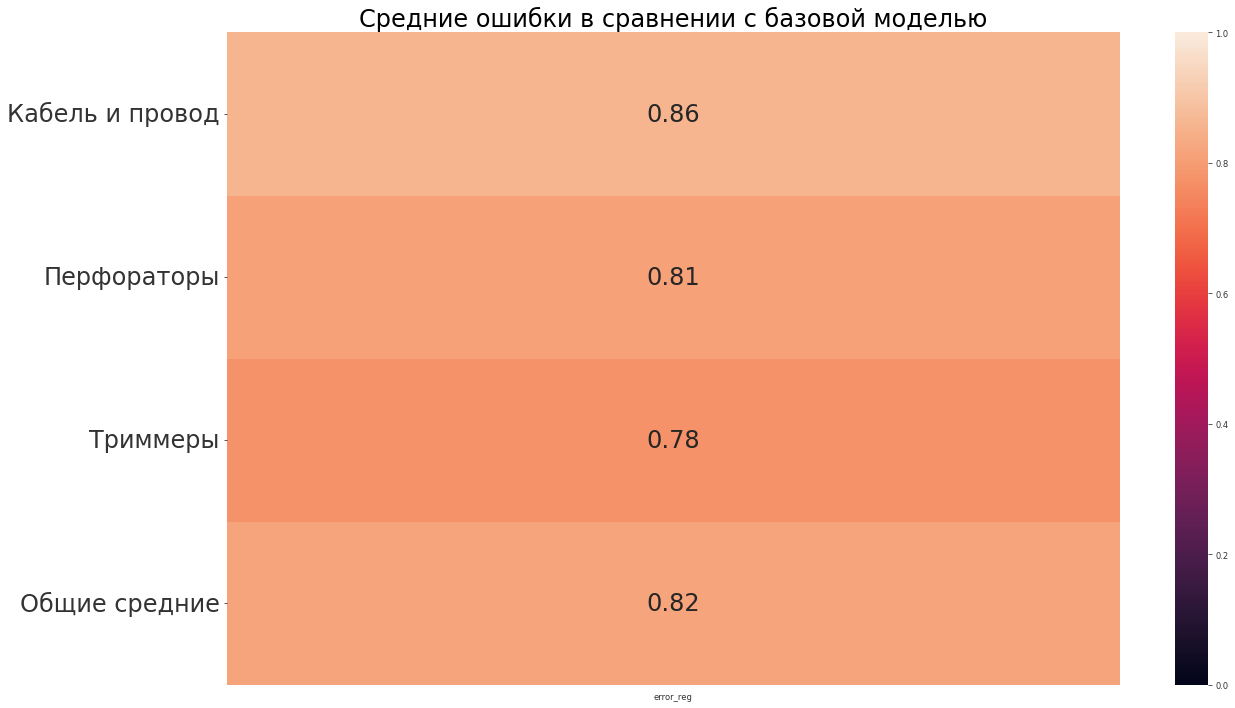

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-08-08
Перфораторы
Using 298 articuls


100%|██████████| 298/298 [15:15<00:00,  3.07s/it]




Found predictions for 298 articuls
Триммеры
Using 385 articuls


 49%|████▉     | 189/385 [13:38<07:03,  2.16s/it]

In [ ]:
date_start = '2020-10-04'
date = date_start
date_end = '2021-09-05'
stride = 4

all_arts = rubric_dict.index.tolist()
while date <= date_end:
  print(f'Forecasting 3 weeks after {date}')
  errors_ls = []
  for rubric in rubrics:
    print(f'{rubric}')
    rubric_arts = rubric_dict.query('rubr_lev1 == @rubric').index.tolist()
    errors_frame_rubric = errors_reg_date_sample(rubric_arts, date, lags_ls_samples, [0])
    errors_ls.append(errors_frame_rubric)

  errors_frame = pd.concat(errors_ls) 
  base_error_compare(errors_frame)
  date = pd.Timestamp(date)
  date += timedelta(weeks=stride)
  date = datetime.strftime(date, "%Y-%m-%d")
  print('------------------------------------------------------------------------\n')
  

Forecasting 3 weeks after 2021-08-08
Перфораторы
Using 298 articuls


100%|██████████| 298/298 [16:19<00:00,  3.29s/it]




Found predictions for 298 articuls
Триммеры
Using 385 articuls


100%|██████████| 385/385 [16:18<00:00,  2.54s/it]




Found predictions for 385 articuls
Кабель и провод
Using 988 articuls


100%|██████████| 988/988 [17:36<00:00,  1.07s/it]




Found predictions for 988 articuls


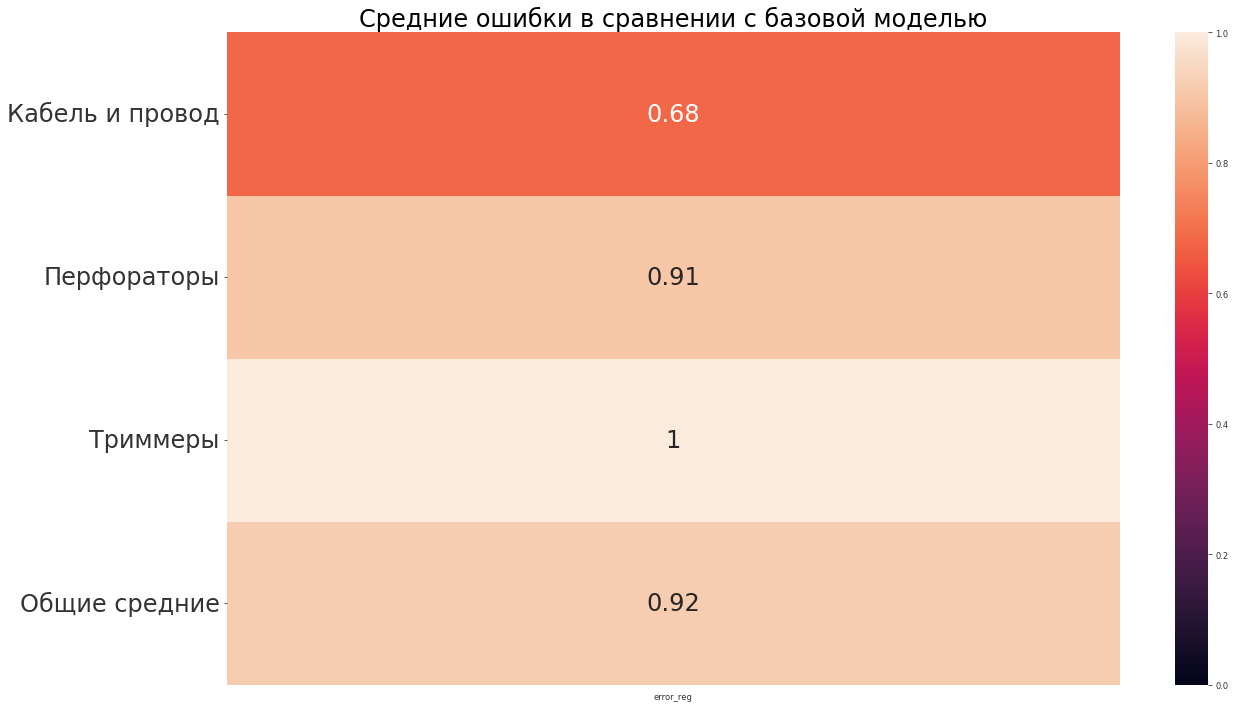

------------------------------------------------------------------------

Forecasting 3 weeks after 2021-09-05
Перфораторы
Using 296 articuls


100%|██████████| 296/296 [16:45<00:00,  3.40s/it]




Found predictions for 296 articuls
Триммеры
Using 364 articuls


100%|██████████| 364/364 [16:42<00:00,  2.75s/it]




Found predictions for 364 articuls
Кабель и провод
Using 1056 articuls


100%|██████████| 1056/1056 [18:29<00:00,  1.05s/it]




Found predictions for 1056 articuls


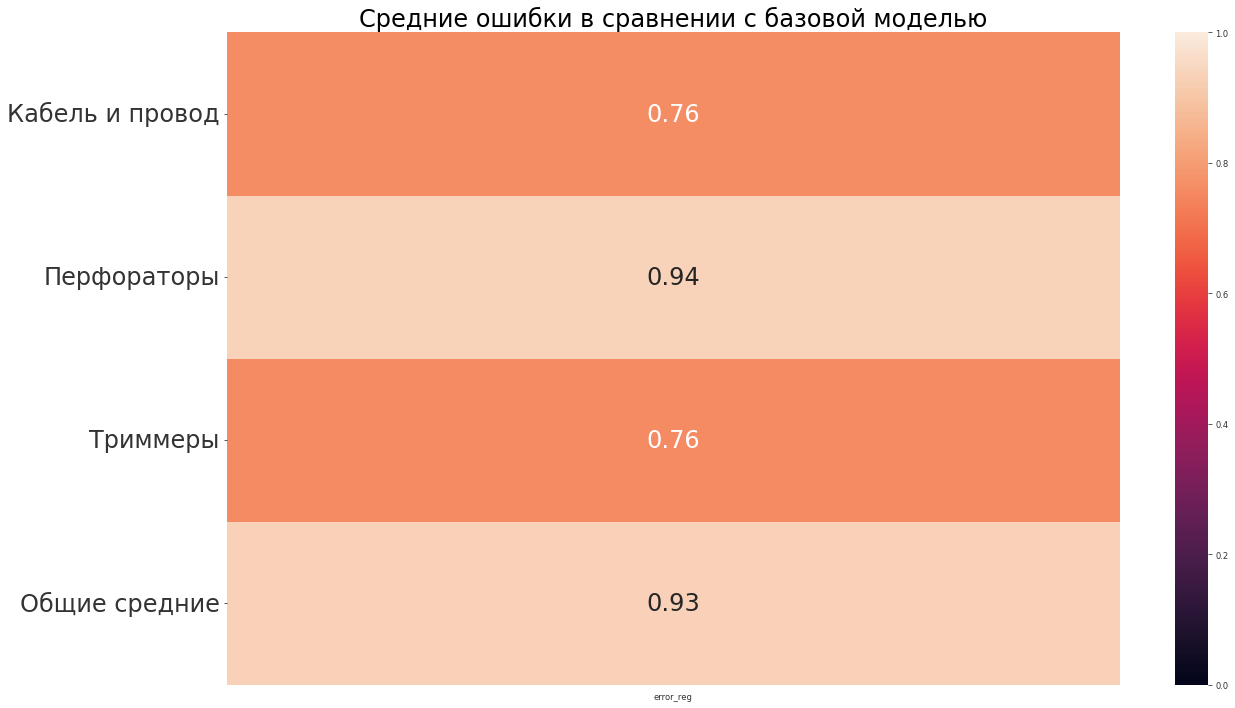

------------------------------------------------------------------------



In [20]:
date_start = '2021-08-08'
date = date_start
date_end = '2021-09-05'
stride = 4

all_arts = rubric_dict.index.tolist()
while date <= date_end:
  print(f'Forecasting 3 weeks after {date}')
  errors_ls = []
  for rubric in rubrics:
    print(f'{rubric}')
    rubric_arts = rubric_dict.query('rubr_lev1 == @rubric').index.tolist()
    errors_frame_rubric = errors_reg_date_sample(rubric_arts, date, lags_ls_samples, [0])
    errors_ls.append(errors_frame_rubric)

  errors_frame = pd.concat(errors_ls) 
  base_error_compare(errors_frame)
  date = pd.Timestamp(date)
  date += timedelta(weeks=stride)
  date = datetime.strftime(date, "%Y-%m-%d")
  print('------------------------------------------------------------------------\n')
  

## Tuning on everything


### Scale, covariates and split

In [ ]:
def scale_split_cov(art_sample, date='20210912'):
    scaler_dict = {}
    covs_dict = {}
    ts_train_dict = {}
    ts_val_dict = {}

    covs_train_dict = {}
    covs_val_dict = {}
        
    for art in art_sample:
        ts_act = ts_act_dict[art]
        train_act, val_act = ts_act.split_after(pd.Timestamp(date))
        
        scaler = Scaler()
        train = scaler.fit_transform(train_act)
        val = scaler.transform(val_act)
        scaler_dict[art] = scaler
        ts_train_dict[art] = train
        ts_val_dict[art] = val

        covariates = datetime_attribute_timeseries(ts_act, attribute='year', one_hot=False)
        covariates = covariates.stack(datetime_attribute_timeseries(ts_act, attribute='month', one_hot=False))
        covariates = covariates.stack(TimeSeries.from_times_and_values(times=ts_act.time_index, values=np.arange(len(ts_act)), columns=['linear_increase']))
        covariates = covariates.astype(np.float32)
        
        train_covs, val_covs = covariates.split_after(pd.Timestamp(date))

        scaler_covs = Scaler()
        scaler_covs.fit(train_covs)
        covariates = scaler_covs.transform(covariates)
        covs_dict[art] = covariates
        covs_val_dict[art] = val
        covs_train_dict[art] = train
        
    return ts_train_dict, ts_val_dict, covs_dict, covs_val_dict, covs_train_dict, scaler_dict

scale_split_cov(rubric_dict.index[:5]);

### Функция прогноза на заданную дату

In [ ]:
def errors_reg_date_sample(art_ls, date, lags, lags_future_covariates, good=False):

    df_sample = df_weekly.query('articul in @art_ls')

    if good:
      df_sample, art_ls = goodify(df_sample, date)

    
    ts_train_dict, ts_val_dict, covs_dict, covs_val_dict, covs_train_dict,\
    scaler_dict = scale_split_cov(art_ls, date=date)
    
    train_ls = list(ts_train_dict.values())
    cov_ls = list(covs_dict.values())
    
    
    reg_model = RegressionModel(lags= lags,
                                #lags_past_covariates = [-3,-2,-1],
                               lags_future_covariates = lags_future_covariates)
    reg_model.fit(series=train_ls,
                  #past_covariates=list(covs_train_dict.values()),
                  future_covariates=cov_ls)
                  #val_series=ts_val_list,
                  #val_past_covariates=month_val_list)
    predict_reg = reg_model.predict(3,
                                    series = train_ls,
                                    future_covariates = cov_ls)   
    error_dict= {}
    for i, art in enumerate(art_ls):


        predict_base_sum = ts_train_dict[art][-3:].sum()
        predict_reg_sum = predict_reg[i].sum()
        actual_sum = ts_val_dict[art][:3].sum()

        reg_error = abs(actual_sum - predict_reg_sum).iloc[0]

        base_error = abs(actual_sum - predict_base_sum).iloc[0]
        error_dict[art] = [reg_error, base_error]
        #ts_list[i].plot(label='actual')
        #predict_tft[i].plot()
        #print(tft_error/base_error)
        #plt.show()
        error_frame = pd.DataFrame.from_dict(error_dict, orient='index', columns=['error_reg', 'error_base'])
    return error_frame  

perf_arts = rubric_dict.query('rubr_lev1 == "Перфораторы"').index
errors_reg_date_sample(perf_arts, "2021012", [-1, -2, -3], [0])

KeyboardInterrupt: ignored

### Tune

In [ ]:
lags_ls = [[-1, -2, -3],
           [-49, -50, -51],
           [-102, -103, -104],
           [-155, -156, -157]
    ]

    
lags_ls_samples = [lags_ls[0], 
                   lags_ls[0] + lags_ls[1], 
                   lags_ls[0] + lags_ls[1] + lags_ls[2], 
                   lags_ls[0] + lags_ls[1] + lags_ls[2] + lags_ls[3], 
                   lags_ls[0] + lags_ls[2] + lags_ls[3], 
                   lags_ls[0] + lags_ls[1] + lags_ls[3],
                  lags_ls[0] + lags_ls[1] + lags_ls[2]]
lags_ls_samples

[[-1, -2, -3],
 [-1, -2, -3, -49, -50, -51],
 [-1, -2, -3, -49, -50, -51, -102, -103, -104],
 [-1, -2, -3, -49, -50, -51, -102, -103, -104, -155, -156, -157],
 [-1, -2, -3, -102, -103, -104, -155, -156, -157],
 [-1, -2, -3, -49, -50, -51, -155, -156, -157],
 [-1, -2, -3, -49, -50, -51, -102, -103, -104]]

In [ ]:
lags_ls_samples_zero =[[0]] + [[0, -1]] + [[0] + ls for ls in lags_ls_samples]
lags_ls_samples_zero

[[0],
 [0, -1],
 [0, -1, -2, -3],
 [0, -1, -2, -3, -49, -50, -51],
 [0, -1, -2, -3, -49, -50, -51, -102, -103, -104],
 [0, -1, -2, -3, -49, -50, -51, -102, -103, -104, -155, -156, -157],
 [0, -1, -2, -3, -102, -103, -104, -155, -156, -157],
 [0, -1, -2, -3, -49, -50, -51, -155, -156, -157],
 [0, -1, -2, -3, -49, -50, -51, -102, -103, -104]]

In [ ]:
def tune_lags_predict_error(art_ls, date, 
                            lags=lags_ls_samples, 
                            cov_lags=lags_ls_samples_zero):
    df_sample = df_weekly.query('articul in @art_ls')

    
    df_sample, art_ls = goodify(df_sample, date)

    date_tune = pd.Timestamp(date) - timedelta(weeks=3)
    date_tune = datetime.strftime(date_tune, '%Y-%m-%d')
    error_min = np.inf
    for lag in lags:
        for lag_cov in cov_lags:
            error_frame = errors_reg_date_sample(art_ls, date_tune, lag, lag_cov, good=False)
            medians = error_frame.abs().median()
            error_base_scale = medians.iloc[0] / medians.iloc[1]
            if error_base_scale < error_min:
                error_min = error_base_scale 
                best_lag = lag
                best_lag_cov = lag_cov
            else:
                continue
    
    print(f'Best lag is {best_lag}')
    print(f'Best covariate lag is {best_lag_cov}')
    print(f'Error min is {error_min}')
    error_frame_rubric = errors_reg_date_sample(art_ls, date, best_lag, best_lag_cov)
    
    return error_frame_rubric

#error_frame_perf = tune_lags_predict_error('Перфораторы', '2021-09-12')
    
    
            

In [ ]:
error_frame_perf.abs().mean()

error_reg     0.332399
error_base    0.328248
dtype: float64

#### September

In [ ]:
rubrics

['Перфораторы', 'Триммеры', 'Кабель и провод']

In [ ]:
def tune_error_all(date):
   
    t = time()
    error_frame_all = []
    for rubric in tqdm(rubrics, desc=f'Tuning on rubric'):
        print('-----------------------------------------------------------------------\n')
        print(f'Rubric is {rubric}')
        
        rubric_art_ls = rubric_dict.query('rubr_lev1 == @rubric').index.tolist()
        error_frame = tune_lags_predict_error(rubric_art_ls, date)
        error_frame_all.append(error_frame)              
          
    error_frame_all = pd.concat(error_frame_all)
    error_frame_all = error_frame_all.reset_index().rename(columns={'index': 'articul'})
    t = time() - t
    print(t/60)

    return base_error_compare(error_frame_all)

In [ ]:
 
t = time()
error_frame_all = []
for rubric in tqdm(rubrics, desc=f'Tuning on rubric'):
    print('-----------------------------------------------------------------------\n')
    print(f'Rubric is {rubric}')
    
    rubric_art_ls = rubric_dict.query('rubr_lev1 == @rubric').index.tolist()
    error_frame = tune_lags_predict_error(rubric_art_ls, '2021-09-12')
    error_frame_all.append(error_frame)              
       
error_frame_all = pd.concat(error_frame_all)
error_frame_all = error_frame_all.reset_index().rename(columns={'index': 'articul'})
t = time() - t
print(t/60)

Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -49, -50, -51, -102, -103, -104, -155, -156, -157]
Best covariate lag is [0, -1]
Error min is 1.0089970095325145


Tuning on rubric:  33%|███▎      | 1/3 [19:17<38:34, 1157.26s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -49, -50, -51, -102, -103, -104]
Best covariate lag is [0, -1, -2, -3, -49, -50, -51]
Error min is 0.8278558320024924


Tuning on rubric:  67%|██████▋   | 2/3 [36:17<17:56, 1076.37s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3]
Best covariate lag is [0, -1, -2, -3, -49, -50, -51, -102, -103, -104]
Error min is 0.6257269209952044


Tuning on rubric: 100%|██████████| 3/3 [40:01<00:00, 800.37s/it]

40.01839288473129


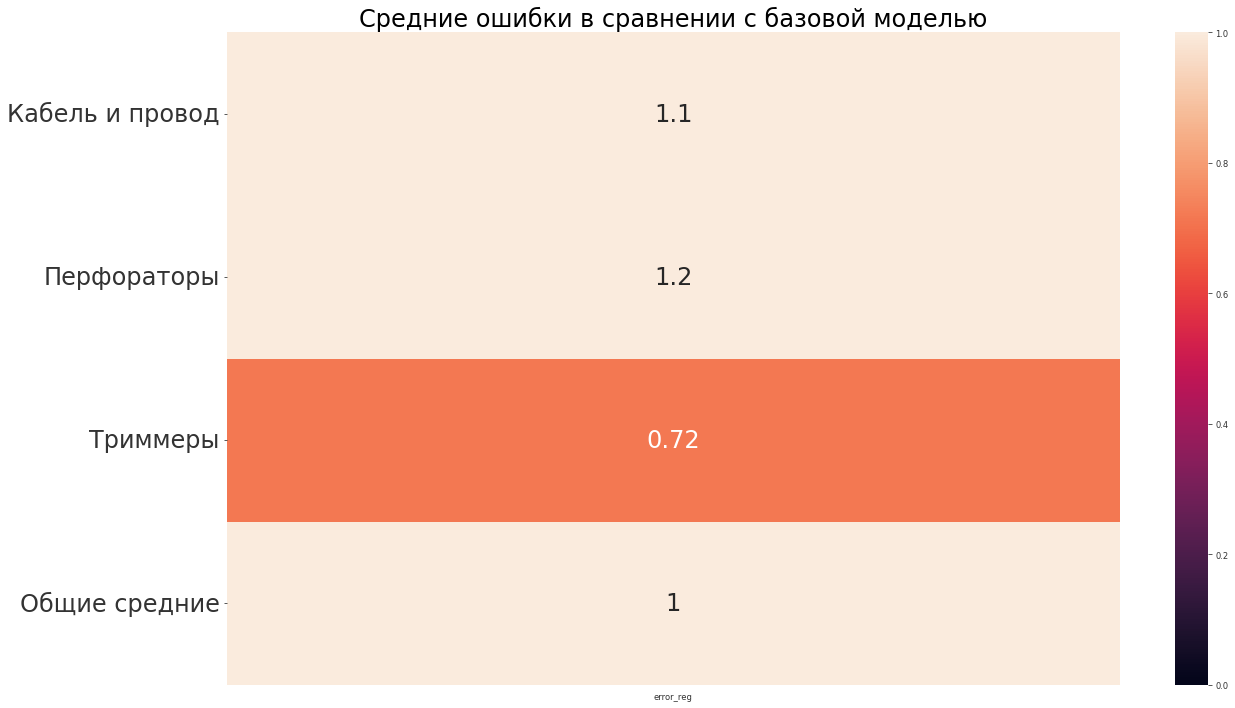

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.708333,0.754514
Перфораторы,0.278125,0.333136
Триммеры,0.164474,0.118179
Общие средние,0.212121,0.215276


In [ ]:
def base_scale_heatmap(df, df_for_means, show_means=True):
    df_base_scale = df.drop(['error_base'], axis=1).div(df['error_base'], axis=0)
    if show_means:
        means = df_for_means.abs().median()
        means = means / means['error_base']
        means = means.drop('error_base')
        means.name = 'Общие средние'
        df_base_scale = df_base_scale.append(means)
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.heatmap(df_base_scale, vmin=0, vmax=1, annot=True, annot_kws={"size": 24})
    plt.title('Средние ошибки в сравнении с базовой моделью', size=24)
    plt.ylabel('')
    plt.yticks(rotation=0, size=24)
    plt.xticks(None)
    plt.xlabel(None)
    plt.show() 
    return(df_base_scale)

def base_error_compare(error, category_list = ['rubr_lev1'], show_means=True, query=None):
    #base_error = base_error.merge(art_rubric_dict, on='articul')
    errors = pd.merge(rubric_dict, error, on='articul')
    if query:    
        errors = errors.query(query)
    #display(errors.sort_values(by='error_rbf', ascending=False).head(20))
    MAE_errors = errors.groupby(category_list).apply(lambda x : x[['error_base', 'error_reg']].abs().median())

    base_scale_heatmap(MAE_errors, errors[['error_base', 'error_reg']], show_means=show_means)
    
    

    return (MAE_errors.append(errors[['error_base', 'error_reg']].abs().median().rename('Общие средние')))


base_error_compare(error_frame_all, query=None)

#### July

Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -49, -50, -51, -155, -156, -157]
Best covariate lag is [0, -1, -2, -3, -102, -103, -104, -155, -156, -157]
Error min is 0.8417588980740107


Tuning on rubric:  33%|███▎      | 1/3 [20:05<40:10, 1205.46s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -49, -50, -51, -102, -103, -104, -155, -156, -157]
Best covariate lag is [0, -1, -2, -3, -49, -50, -51, -102, -103, -104]
Error min is 0.4691065746156958


Tuning on rubric:  67%|██████▋   | 2/3 [42:25<21:24, 1284.51s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3]
Best covariate lag is [0, -1, -2, -3]
Error min is 0.7793543402213459


Tuning on rubric: 100%|██████████| 3/3 [47:05<00:00, 941.84s/it]


47.09239062468211


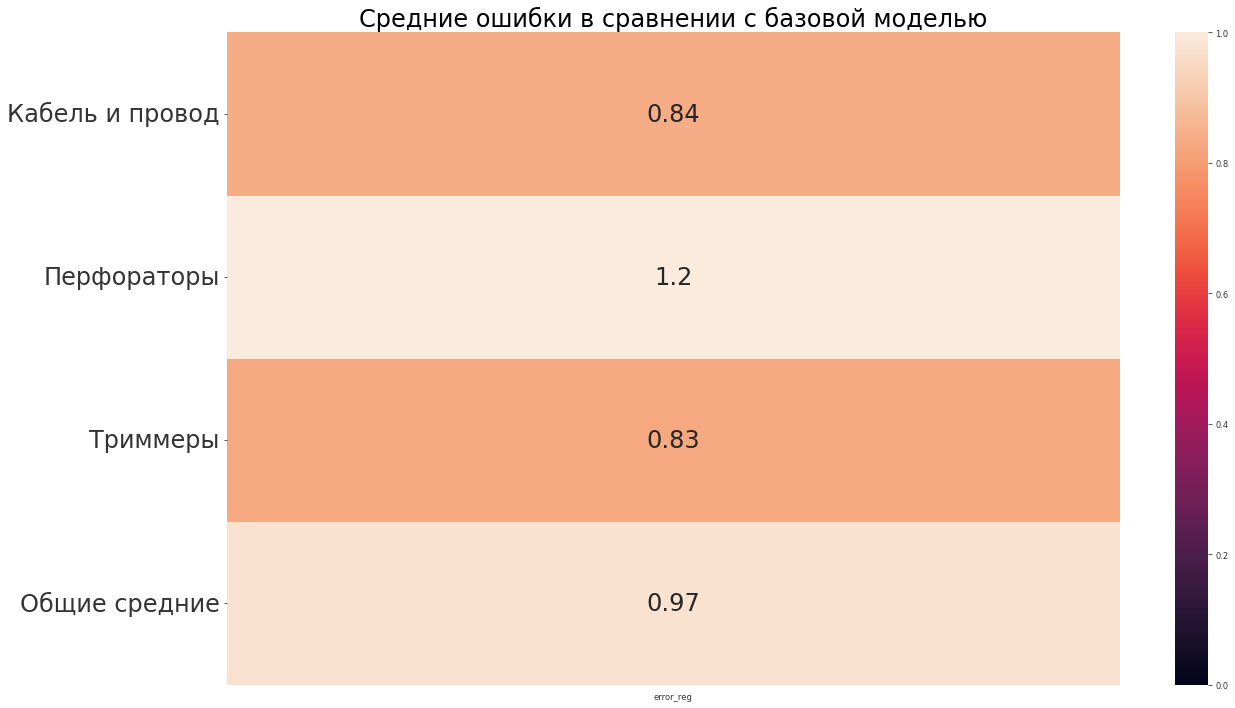

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.416667,0.348480
Перфораторы,0.248077,0.301884
Триммеры,0.243590,0.202004
Общие средние,0.250000,0.243711


In [ ]:
tune_error_all('2021-07-18')

#### May

Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -49, -50, -51]
Best covariate lag is [0, -1, -2, -3, -49, -50, -51, -102, -103, -104, -155, -156, -157]
Error min is 0.924068132687183


Tuning on rubric:  33%|███▎      | 1/3 [18:09<36:18, 1089.48s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3]
Best covariate lag is [0]
Error min is 0.7435355750708641


Tuning on rubric:  67%|██████▋   | 2/3 [28:17<13:26, 806.34s/it] 

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -49, -50, -51, -102, -103, -104]
Best covariate lag is [0]
Error min is 0.7357515911453645


Tuning on rubric: 100%|██████████| 3/3 [34:18<00:00, 686.18s/it]


34.30907283226649


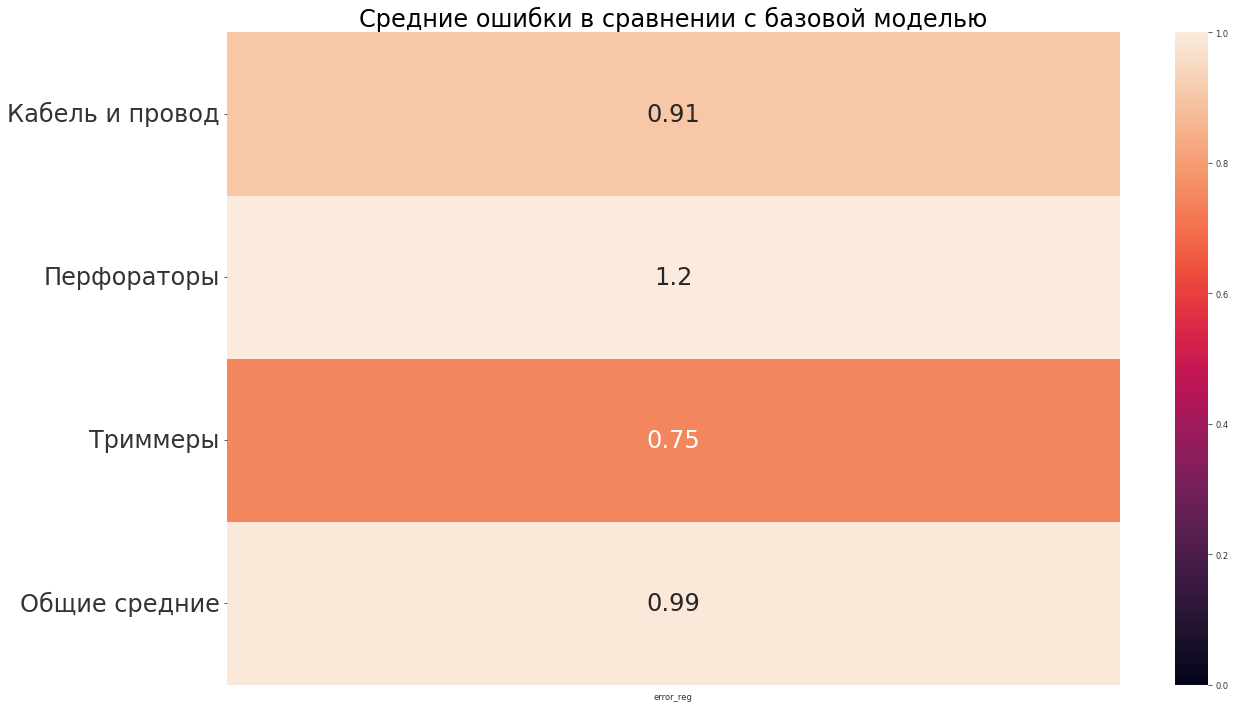

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.333333,0.301852
Перфораторы,0.288118,0.332253
Триммеры,0.293103,0.219292
Общие средние,0.297271,0.294740


In [ ]:
tune_error_all('2021-04-25')

#### March

Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -49, -50, -51]
Best covariate lag is [0]
Error min is 1.228460481236464


Tuning on rubric:  33%|███▎      | 1/3 [17:19<34:38, 1039.19s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -49, -50, -51, -102, -103, -104]
Best covariate lag is [0, -1]
Error min is 0.567726419016839


Tuning on rubric:  67%|██████▋   | 2/3 [22:42<10:18, 618.31s/it] 

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3]
Best covariate lag is [0]
Error min is 0.46648405968834156


Tuning on rubric: 100%|██████████| 3/3 [27:37<00:00, 552.62s/it]


27.630947224299113


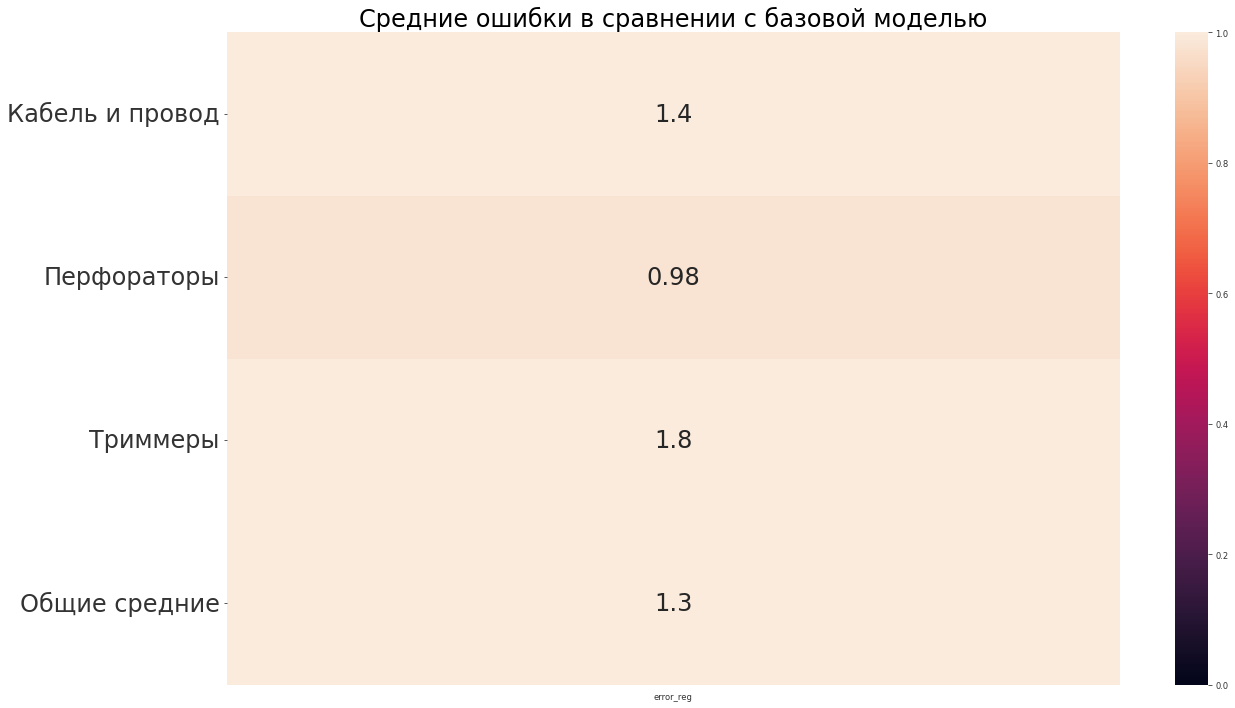

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.196351,0.284457
Перфораторы,0.318182,0.310909
Триммеры,0.041379,0.073314
Общие средние,0.213939,0.267451


In [ ]:
tune_error_all('2021-03-21')

### No tune

In [ ]:
 
t = time()
error_frame_all = []
for rubric in tqdm(rubrics):
    art_rubric_ls = [art for art in art_sample if art in rubric_dict.query('rubr_lev1 == @rubric').index]
    ts_train_rubric = [ts_train_dict[art] for art in art_rubric_ls]
    covs_dict_rubric = [covs_dict[art] for art in art_rubric_ls]
    
    
    
    reg_model = RegressionModel(lags= [-157,-156,-155, -104,-103,-102,-51,-50,-49,-3, -2, -1],
                                #lags_past_covariates = [-3,-2,-1],
                               lags_future_covariates = [-157,-156,-155, -104,-103,-102,-51,-50,-49,-3,-2,-1,0])
    reg_model.fit(series=ts_train_rubric,
                  #past_covariates=list(covs_train_dict.values()),
                  future_covariates=covs_dict_rubric)
                  #val_series=ts_val_list,
                  #val_past_covariates=month_val_list)
    predict_reg = reg_model.predict(3, series = ts_train_rubric, future_covariates = covs_dict_rubric)   
    error_dict= {}
    for i, art in enumerate(art_rubric_ls):


        predict_base_sum = ts_train_dict[art][-3:].sum()
        predict_reg_sum = predict_reg[i].sum()
        actual_sum = ts_val_dict[art].sum()

        reg_error = abs(actual_sum - predict_reg_sum).iloc[0]

        base_error = abs(actual_sum - predict_base_sum).iloc[0]
        error_dict[art] = [reg_error, base_error]
        #ts_list[i].plot(label='actual')
        #predict_tft[i].plot()
        #print(tft_error/base_error)
        #plt.show()

    error_frame = pd.DataFrame.from_dict(error_dict, orient='index', columns=['error_reg', 'error_base'])
    error_frame_all.append(error_frame)              
                  
error_frame_all = pd.concat(error_frame_all)
error_frame_all = error_frame_all.reset_index().rename(columns={'index': 'articul'})


t = time() - t
print(t/60)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.31s/it]

0.4156458457310995


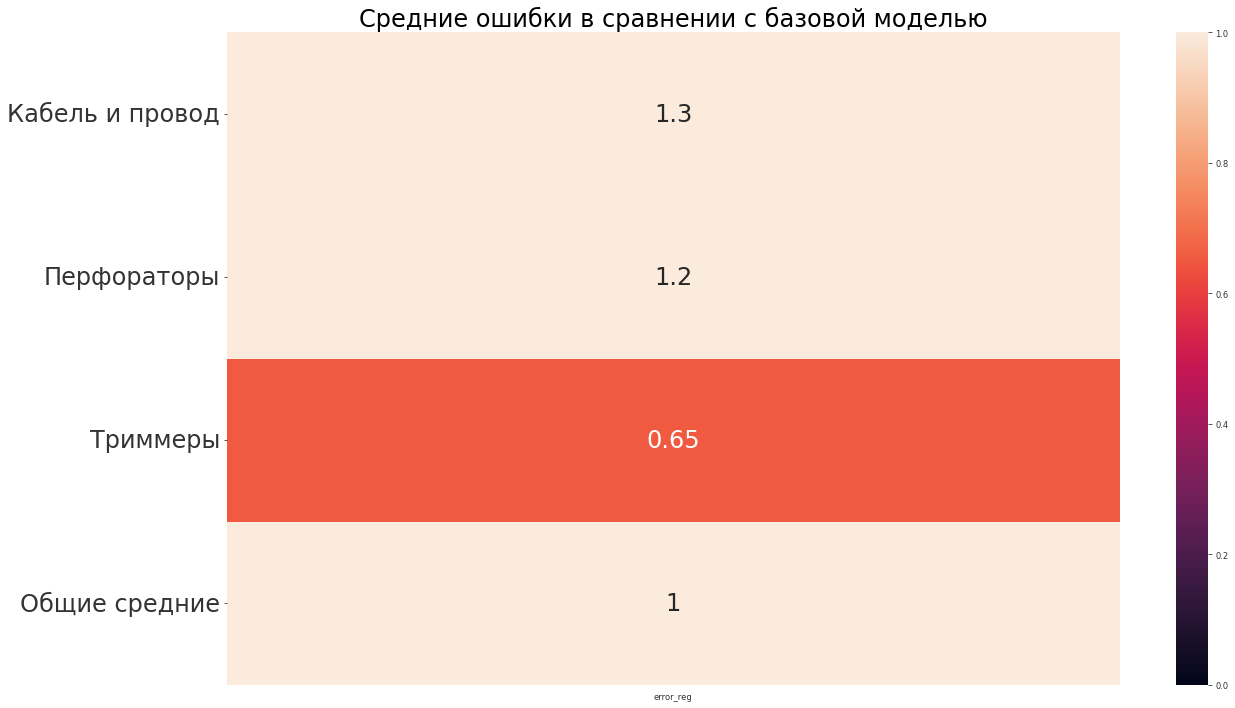

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.250000,0.327866
Перфораторы,0.250000,0.309038
Триммеры,0.148936,0.097358
Общие средние,0.200000,0.207933


In [ ]:
def base_scale_heatmap(df, df_for_means, show_means=True):
    df_base_scale = df.drop(['error_base'], axis=1).div(df['error_base'], axis=0)
    if show_means:
        means = df_for_means.abs().median()
        means = means / means['error_base']
        means = means.drop('error_base')
        means.name = 'Общие средние'
        df_base_scale = df_base_scale.append(means)
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.heatmap(df_base_scale, vmin=0, vmax=1, annot=True, annot_kws={"size": 24})
    plt.title('Средние ошибки в сравнении с базовой моделью', size=24)
    plt.ylabel('')
    plt.yticks(rotation=0, size=24)
    plt.xticks(None)
    plt.xlabel(None)
    plt.show() 
    return(df_base_scale)

def base_error_compare(error, category_list = ['rubr_lev1'], show_means=True, query=None):
    #base_error = base_error.merge(art_rubric_dict, on='articul')
    errors = pd.merge(rubric_dict, error, on='articul')
    if query:    
        errors = errors.query(query)
    #display(errors.sort_values(by='error_rbf', ascending=False).head(20))
    MAE_errors = errors.groupby(category_list).apply(lambda x : x[['error_base', 'error_reg']].abs().median())

    base_scale_heatmap(MAE_errors, errors[['error_base', 'error_reg']], show_means=show_means)
    
    

    return (MAE_errors.append(errors[['error_base', 'error_reg']].abs().median().rename('Общие средние')))


base_error_compare(error_frame_all, query=None)


## Tuning lags on normed sums

В этой секции пытаемся использовать нормированные суммы по рубрике, как прошлые ковариаты, а также тюнить лаги по ним, используя бэктестинг за год.

#### Normed Sums Sample

In [ ]:
def normed_sum_sample(art_sample, date):
    
    sum_normed = df_weekly.query('articul in @art_sample')\
      .groupby('date')['qty_base_smooth'].agg([sum, lambda x: np.log1p(np.sum(x>0))])\
      .assign(sum_normed = lambda x: x.iloc[:,0]/x.iloc[:,1])['sum_normed']
    
    ts = TimeSeries.from_series(sum_normed, fill_missing_dates=True, fillna_value=0, freq='W')

    train, val = ts.split_after(pd.Timestamp(date))
  
    scaler = Scaler()
    train = scaler.fit_transform(train)
    ts_sc = scaler.transform(ts)

    return train, ts_sc

### Scale, covariates and split

In [ ]:
def scale_split_cov(art_sample, date='20210912'):
    scaler_dict = {}
    covs_dict = {}
    ts_train_dict = {}
    ts_val_dict = {}

    covs_train_dict = {}
    covs_val_dict = {}
        
    for art in art_sample:
        ts_act = ts_act_dict[art]
        train_act, val_act = ts_act.split_after(pd.Timestamp(date))
        
        scaler = Scaler()
        train = scaler.fit_transform(train_act)
        val = scaler.transform(val_act)
        scaler_dict[art] = scaler
        ts_train_dict[art] = train
        ts_val_dict[art] = val

        covariates = datetime_attribute_timeseries(ts_act, attribute='year', one_hot=False)
        covariates = covariates.stack(datetime_attribute_timeseries(ts_act, attribute='month', one_hot=False))
        covariates = covariates.stack(TimeSeries.from_times_and_values(times=ts_act.time_index, values=np.arange(len(ts_act)), columns=['linear_increase']))
        covariates = covariates.astype(np.float32)
        
        train_covs, val_covs = covariates.split_after(pd.Timestamp(date))

        scaler_covs = Scaler()
        scaler_covs.fit(train_covs)
        covariates = scaler_covs.transform(covariates)
        covs_dict[art] = covariates
        covs_val_dict[art] = val
        covs_train_dict[art] = train
        
    return ts_train_dict, ts_val_dict, covs_dict, covs_val_dict, covs_train_dict, scaler_dict

scale_split_cov(rubric_dict.index[:5]);

### Функция прогноза на заданную дату

In [ ]:
def errors_reg_date_sample(art_ls, date, lags, lags_future_covariates,
                           future_covariates=True,  
                           past_covariates=False, lags_past_covariates=None, good=False):

    df_sample = df_weekly.query('articul in @art_ls')

    if good:
      df_sample, art_ls = goodify(df_sample, date)

    
    ts_train_dict, ts_val_dict, covs_dict, covs_val_dict, covs_train_dict,\
    scaler_dict = scale_split_cov(art_ls, date=date)
    
    train_ls = list(ts_train_dict.values())
    cov_ls = list(covs_dict.values())
    
    if past_covariates:
        train_past_cov, past_cov = normed_sum_sample(art_ls, date)
        past_train_covs_ls = [train_past_cov for _ in range(len(train_ls))]
        past_covs_ls = [past_cov for _ in range(len(train_ls))]
    else:
        past_covs_ls = None
        past_train_covs_ls = None
        lags_past_covariates = None

    if not future_covariates:    
        lags_future_covariates=None
        cov_ls=None

    reg_model = RegressionModel(lags= lags,
                                lags_past_covariates = lags_past_covariates,
                                lags_future_covariates = lags_future_covariates, 
                                model=Ridge(alpha=1))
    reg_model.fit(series=train_ls,
                  past_covariates=past_train_covs_ls,
                  future_covariates=cov_ls)
                  #val_series=ts_val_list,
                  #val_past_covariates=month_val_list)
    predict_reg = reg_model.predict(3,
                                    series = train_ls,
                                    past_covariates = past_covs_ls,
                                    future_covariates = cov_ls)   
    error_dict= {}
    for i, art in enumerate(art_ls):


        predict_base_sum = ts_train_dict[art][-3:].sum()
        predict_reg_sum = predict_reg[i].sum()
        actual_sum = ts_val_dict[art][:3].sum()

        reg_error = abs(actual_sum - predict_reg_sum).iloc[0]

        base_error = abs(actual_sum - predict_base_sum).iloc[0]
        error_dict[art] = [reg_error, base_error]
        #ts_list[i].plot(label='actual')
        #predict_tft[i].plot()
        #print(tft_error/base_error)
        #plt.show()
        error_frame = pd.DataFrame.from_dict(error_dict, orient='index', columns=['error_reg', 'error_base'])
    return error_frame  

perf_arts = rubric_dict.query('rubr_lev1 == "Перфораторы"').index
errors_reg_date_sample(perf_arts, "20210905", [-1, -2, -3], [0], 
                       future_covariates=False,
                       good=True, 
                       past_covariates=False).abs().median()

error_reg     0.240187
error_base    0.191489
dtype: float64

### Tune

In [ ]:
lags_ls = [[-1, -2, -3],
           [-51, -52, -53],
           [-103, -104, -105],
           [-155, -156, -157]
    ]

    
lags_ls_samples = [[-1, -2],
                   lags_ls[0], 
                   lags_ls[0] + lags_ls[1], 
                   lags_ls[0] + lags_ls[1] + lags_ls[2], 
                   lags_ls[0] + lags_ls[1] + lags_ls[2] + lags_ls[3], 
                   lags_ls[0] + lags_ls[2] + lags_ls[3], 
                   lags_ls[0] + lags_ls[1] + lags_ls[3],
                  lags_ls[0] + lags_ls[1] + lags_ls[2]]
lags_ls_samples

[[-1, -2],
 [-1, -2, -3],
 [-1, -2, -3, -51, -52, -53],
 [-1, -2, -3, -51, -52, -53, -103, -104, -105],
 [-1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157],
 [-1, -2, -3, -103, -104, -105, -155, -156, -157],
 [-1, -2, -3, -51, -52, -53, -155, -156, -157],
 [-1, -2, -3, -51, -52, -53, -103, -104, -105]]

In [ ]:
lags_ls_samples_zero =[[0]] + [[0, -1]] + [[0] + ls for ls in lags_ls_samples]
lags_ls_samples_zero

[[0],
 [0, -1],
 [0, -1, -2],
 [0, -1, -2, -3],
 [0, -1, -2, -3, -51, -52, -53],
 [0, -1, -2, -3, -51, -52, -53, -103, -104, -105],
 [0, -1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157],
 [0, -1, -2, -3, -103, -104, -105, -155, -156, -157],
 [0, -1, -2, -3, -51, -52, -53, -155, -156, -157],
 [0, -1, -2, -3, -51, -52, -53, -103, -104, -105]]

In [ ]:
def tune_lags_on_rep_predict_error(art_ls, date, 
                            lags=lags_ls_samples, 
                            cov_lags=lags_ls_samples_zero):
    df_sample = df_weekly.query('articul in @art_ls')

    
    df_sample, art_ls = goodify(df_sample, date)

    

    date_tune = pd.Timestamp(date) - timedelta(weeks=3)
    date_tune = datetime.strftime(date_tune, '%Y-%m-%d')
    error_min = np.inf

    date_start = pd.Timestamp(date) - timedelta(weeks=8)

    tune_ts_train, tune_ts_all = normed_sum_sample(art_ls, date)

    #display(tune_ts_train[-10:])

    covariates = datetime_attribute_timeseries(tune_ts_all, attribute='year', one_hot=False)
    covariates = covariates.stack(datetime_attribute_timeseries(tune_ts_all, attribute='month', one_hot=False))
    covariates = covariates.stack(TimeSeries.from_times_and_values(times=tune_ts_all.time_index, values=np.arange(len(tune_ts_all)), columns=['linear_increase']))
    covariates = covariates.astype(np.float32)
    

    for lag in lags:
        for use_covs in [False, True]:
            if not use_covs:
                model = RegressionModel(lags=lag, 
                                        lags_future_covariates=None,
                                        model=Ridge(alpha=1))

                error = model.backtest(tune_ts_train, 
                                       future_covariates=None, 
                                       start=date_start, 
                                       stride=1, 
                                       forecast_horizon=3, 
                                       metric=mae)
                if error < error_min:
                    error_min = error 
                    best_lag = lag
                    best_use_covs = use_covs
             
            else:
                for lag_cov in cov_lags:
                    model = RegressionModel(lags=lag, 
                                            lags_future_covariates=lag_cov,
                                            model=Ridge(alpha=1))
                
                    error = model.backtest(tune_ts_train, 
                                           future_covariates=covariates, 
                                           start=date_start, 
                                           stride=1, 
                                           forecast_horizon=3, 
                                           metric=mae)
                    if error < error_min:
                        error_min = error
                        best_use_covs = use_covs
                        best_lag = lag
                        best_lag_cov = lag_cov   

    print(f'Best lag is {best_lag}')
    print(f'Use covariates is {best_use_covs}')
    if best_use_covs:
      print(f'Best covariate lag is {best_lag_cov}')
    else:
      best_lag_cov=None  
    print(f'Error min is {error_min}')
    error_frame_rubric = errors_reg_date_sample(art_ls, date, best_lag, best_lag_cov,
                                                future_covariates=best_use_covs)
    
    return error_frame_rubric

error_frame_perf = tune_lags_on_rep_predict_error(perf_arts, '2021-09-05')
    
    
            

Best lag is [-1, -2, -3]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -103, -104, -105, -155, -156, -157]
Error min is 0.04275017907208874


In [ ]:
error_frame_perf.abs().median()

error_reg     0.240730
error_base    0.191489
dtype: float64

#### September

In [ ]:
rubrics

In [ ]:
def base_scale_heatmap(df, df_for_means, show_means=True):
    df_base_scale = df.drop(['error_base'], axis=1).div(df['error_base'], axis=0)
    if show_means:
        means = df_for_means.abs().median()
        means = means / means['error_base']
        means = means.drop('error_base')
        means.name = 'Общие средние'
        df_base_scale = df_base_scale.append(means)
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.heatmap(df_base_scale, vmin=0, vmax=1, annot=True, annot_kws={"size": 24})
    plt.title('Средние ошибки в сравнении с базовой моделью', size=24)
    plt.ylabel('')
    plt.yticks(rotation=0, size=24)
    plt.xticks(None)
    plt.xlabel(None)
    plt.show() 
    return(df_base_scale)

def base_error_compare(error, category_list = ['rubr_lev1'], show_means=True, query=None):
    #base_error = base_error.merge(art_rubric_dict, on='articul')
    errors = pd.merge(rubric_dict, error, on='articul')
    if query:    
        errors = errors.query(query)
    #display(errors.sort_values(by='error_rbf', ascending=False).head(20))
    MAE_errors = errors.groupby(category_list).apply(lambda x : x[['error_base', 'error_reg']].abs().median())

    base_scale_heatmap(MAE_errors, errors[['error_base', 'error_reg']], show_means=show_means)
    
    

    return (MAE_errors.append(errors[['error_base', 'error_reg']].abs().median().rename('Общие средние')))

Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -103, -104, -105, -155, -156, -157]
Use covariates is True
Best covariate lag is [0]
Error min is 0.0782777476380416


Tuning on rubric:  33%|███▎      | 1/3 [01:22<02:44, 82.35s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105]
Use covariates is True
Best covariate lag is [0, -1]
Error min is 0.030322356811504973


Tuning on rubric:  67%|██████▋   | 2/3 [02:37<01:18, 78.08s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105]
Use covariates is True
Best covariate lag is [0, -1]
Error min is 0.05810295244103894


Tuning on rubric: 100%|██████████| 3/3 [03:44<00:00, 74.97s/it]


3.7484286308288572


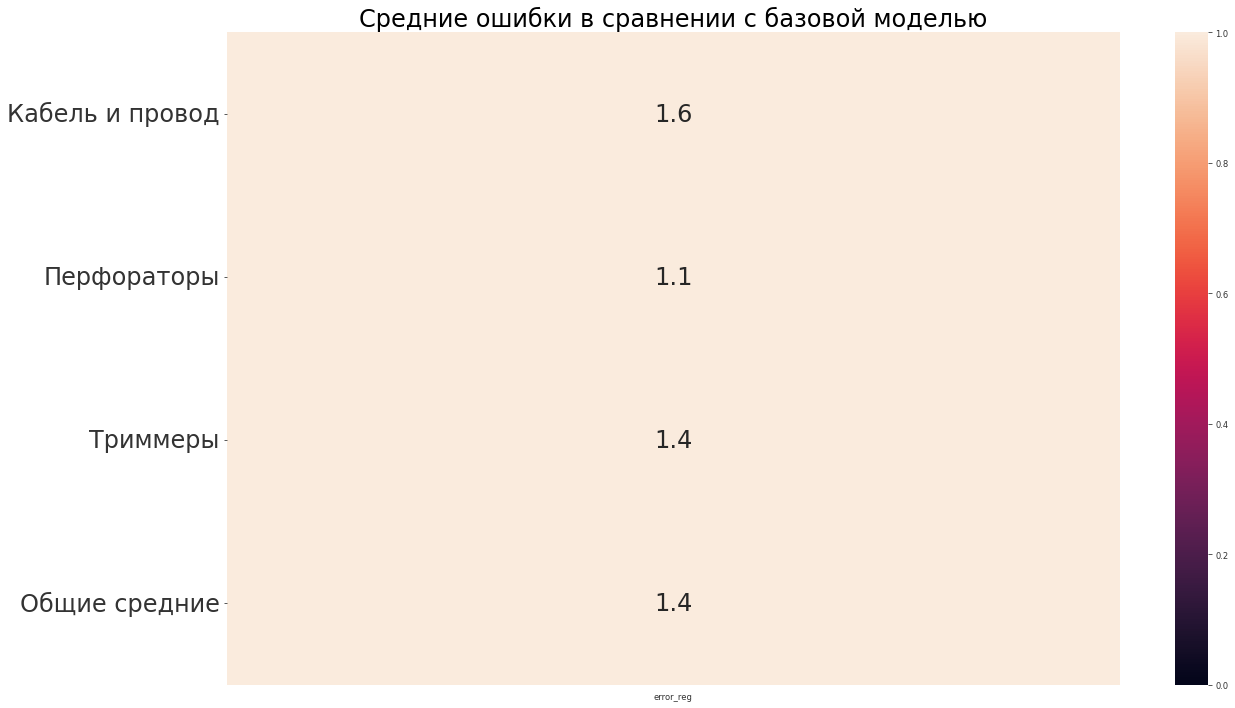

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.142857,0.230803
Перфораторы,0.285714,0.301472
Триммеры,0.052632,0.074483
Общие средние,0.150000,0.212646


In [ ]:
def tune_error_all(date):
   
    t = time()
    error_frame_all = []
    for rubric in tqdm(rubrics, desc=f'Tuning on rubric'):
        print('-----------------------------------------------------------------------\n')
        print(f'Rubric is {rubric}')
        
        rubric_art_ls = rubric_dict.query('rubr_lev1 == @rubric').index.tolist()
        error_frame = tune_lags_on_rep_predict_error(rubric_art_ls, date)
        error_frame_all.append(error_frame)              
          
    error_frame_all = pd.concat(error_frame_all)
    error_frame_all = error_frame_all.reset_index().rename(columns={'index': 'articul'})
    t = time() - t
    print(t/60)

    return base_error_compare(error_frame_all)

tune_error_all('2020-12-27')

#### July

Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -102, -103, -104, -155, -156, -157]
Best covariate lag is [0, -1, -2, -3]
Error min is 0.07383392685981985


Tuning on rubric:  33%|███▎      | 1/3 [01:17<02:35, 77.62s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -49, -50, -51, -102, -103, -104]
Best covariate lag is [0]
Error min is 0.04485970338202682


Tuning on rubric:  67%|██████▋   | 2/3 [02:35<01:17, 77.56s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3]
Best covariate lag is [0, -1, -2, -3]
Error min is 0.11934889110023057


Tuning on rubric: 100%|██████████| 3/3 [03:44<00:00, 74.98s/it]


3.748919109503428


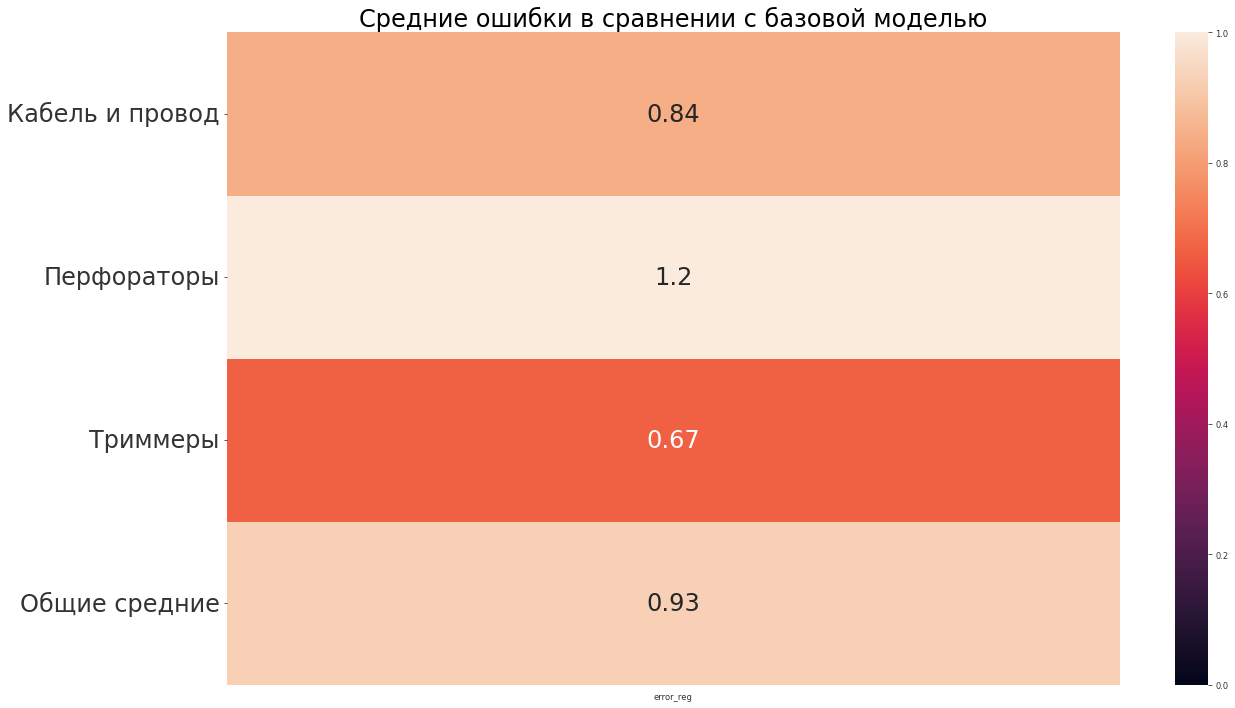

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.416667,0.350616
Перфораторы,0.248077,0.309022
Триммеры,0.243590,0.162213
Общие средние,0.250000,0.231501


In [ ]:
tune_error_all('2021-07-18')

#### May

Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -49, -50, -51, -155, -156, -157]
Best covariate lag is [0, -1, -2, -3, -49, -50, -51]
Error min is 0.0667446639077724


Tuning on rubric:  33%|███▎      | 1/3 [01:15<02:30, 75.03s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -49, -50, -51]
Best covariate lag is [0]
Error min is 0.05256672438709991


Tuning on rubric:  67%|██████▋   | 2/3 [02:26<01:12, 72.92s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3]
Best covariate lag is [0, -1, -2, -3]
Error min is 0.09789581346361395


Tuning on rubric: 100%|██████████| 3/3 [03:36<00:00, 72.13s/it]


3.606763748327891


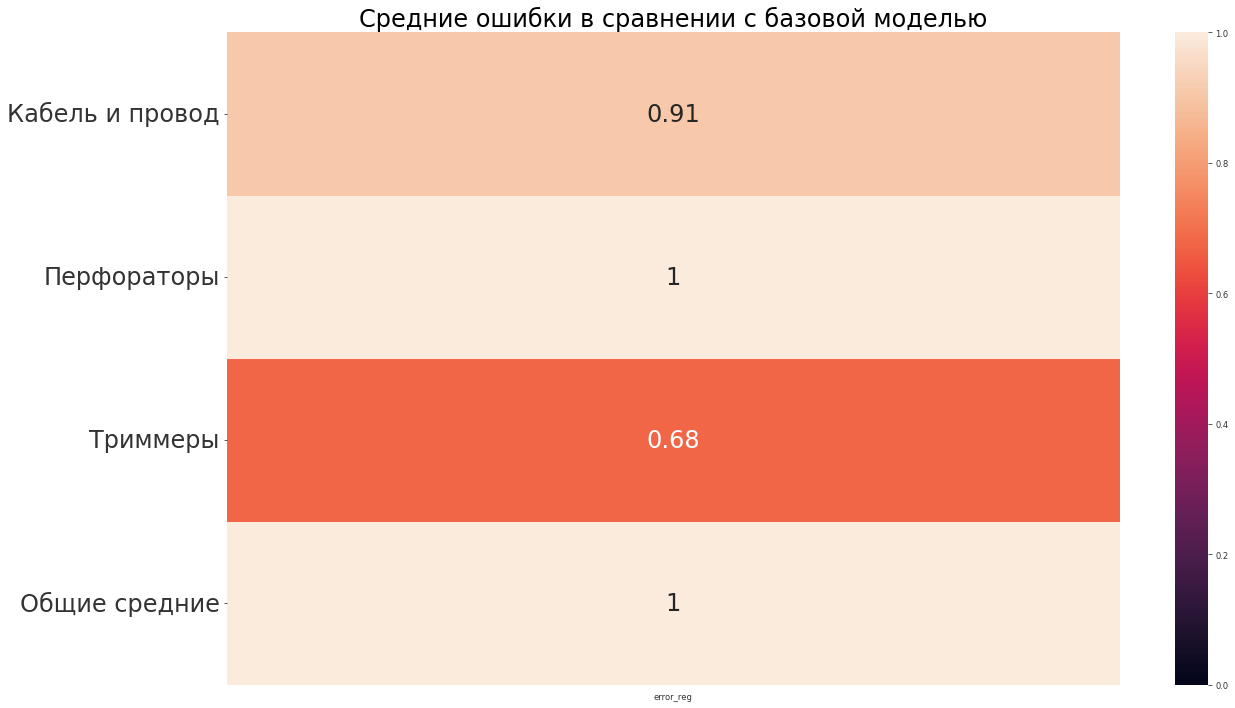

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.333333,0.303030
Перфораторы,0.288118,0.298574
Триммеры,0.293103,0.198201
Общие средние,0.297271,0.296297


In [ ]:
tune_error_all('2021-04-25')

#### March

Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -49, -50, -51]
Best covariate lag is [0, -1, -2, -3, -49, -50, -51]
Error min is 0.07608784120345574


Tuning on rubric:  33%|███▎      | 1/3 [01:15<02:30, 75.12s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -49, -50, -51]
Best covariate lag is [0]
Error min is 0.0524894397008293


Tuning on rubric:  67%|██████▋   | 2/3 [02:24<01:11, 71.76s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3]
Best covariate lag is [0, -1]
Error min is 0.1220459037291819


Tuning on rubric: 100%|██████████| 3/3 [03:33<00:00, 71.23s/it]


3.561797340710958


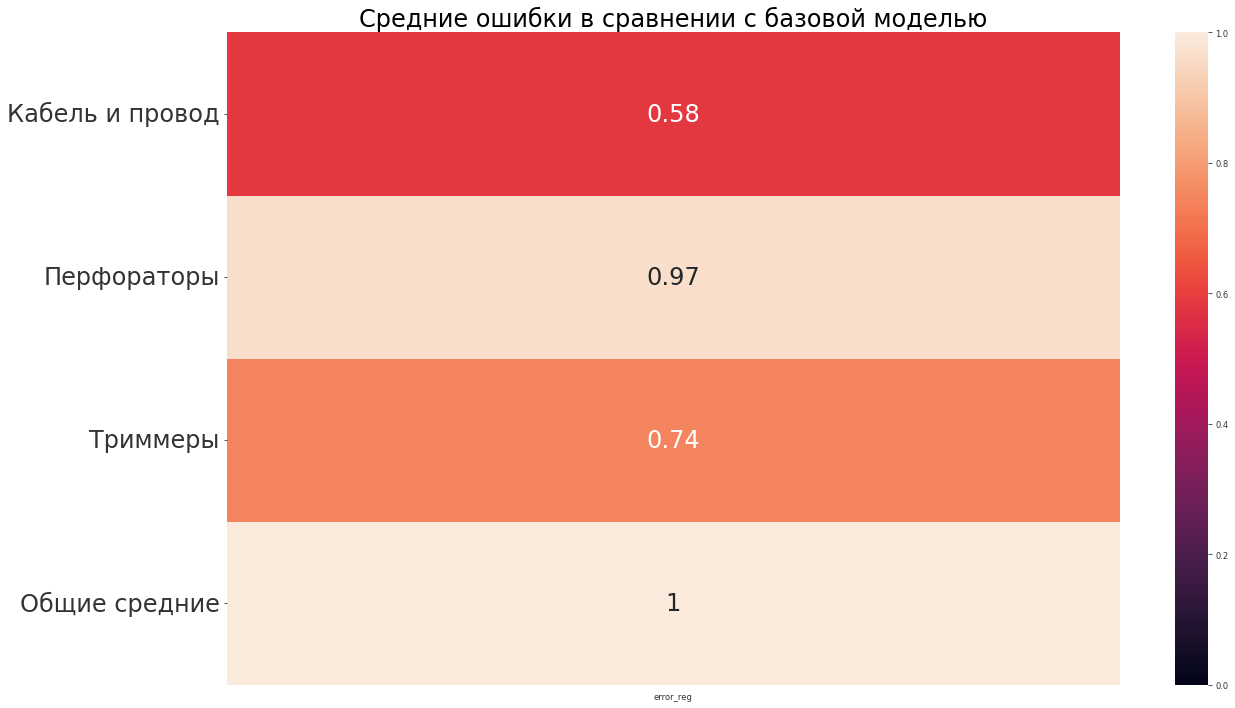

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.250000,0.146109
Перфораторы,0.310268,0.299631
Триммеры,0.090909,0.067627
Общие средние,0.250000,0.261331


In [ ]:
tune_error_all('2021-03-14')

#### All Months

In [ ]:
df_weekly

,articul,date,qty_base_smooth,orders
0,199,2015-08-09,4.0,2
1,199,2015-08-16,5.0,1
2,199,2015-08-23,1.0,1
3,199,2015-08-30,5.0,3
4,199,2015-09-06,2.0,1
...,...,...,...,...
744555,18317623,2021-09-05,3.0,3
744556,18317623,2021-09-12,0.0,0
744557,18317623,2021-09-19,1.0,1
744558,18317623,2021-09-26,1.0,1


Forecasting 3 weeks after 2020-10-04


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157]
Error min is 0.06778529443577205


Tuning on rubric:  33%|███▎      | 1/3 [00:55<01:51, 55.90s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -103, -104, -105, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1, -2, -3]
Error min is 0.030306444521483216


Tuning on rubric:  67%|██████▋   | 2/3 [01:49<00:54, 54.62s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -103, -104, -105, -155, -156, -157]
Error min is 0.09529729768085873


Tuning on rubric: 100%|██████████| 3/3 [02:34<00:00, 51.46s/it]


2.5734071850776674


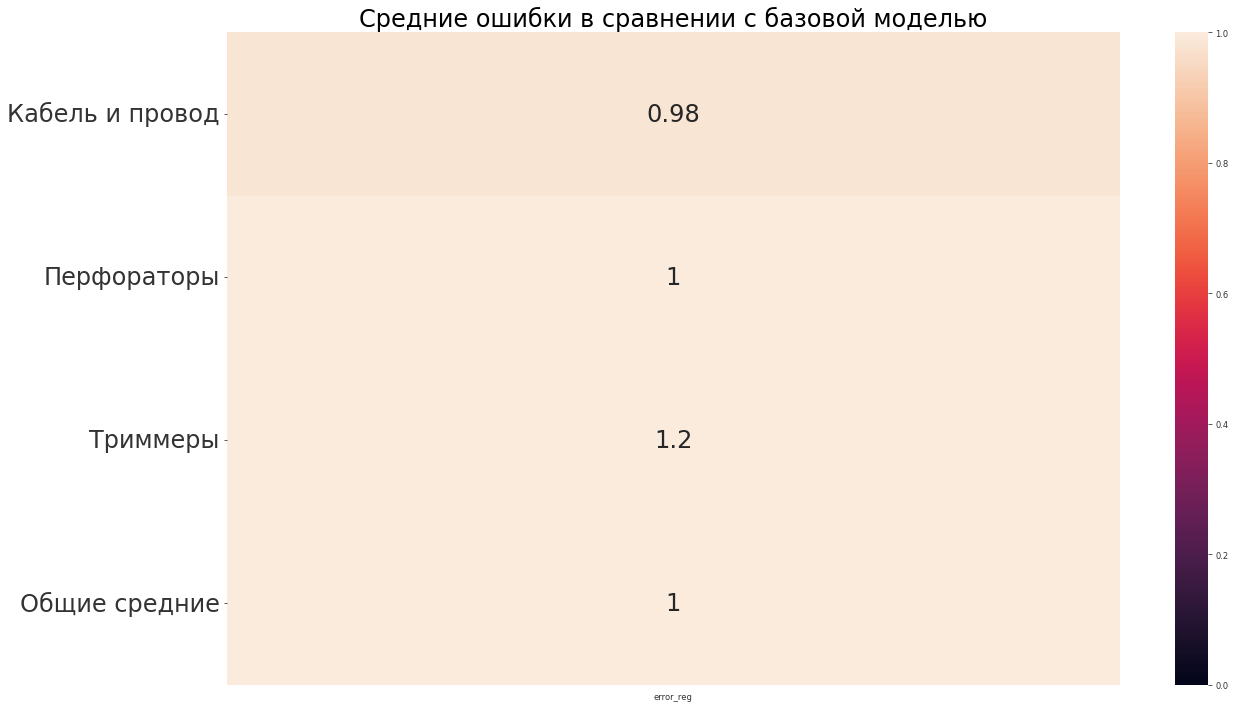

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.307692,0.302633
Перфораторы,0.233688,0.240376
Триммеры,0.095949,0.113010
Общие средние,0.166667,0.173748


------------------------------------------------------------------------

Forecasting 3 weeks after 2020-11-01


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -103, -104, -105, -155, -156, -157]
Error min is 0.0747546768011518


Tuning on rubric:  33%|███▎      | 1/3 [00:55<01:51, 55.89s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105]
Use covariates is True
Best covariate lag is [0, -1]
Error min is 0.012701621905416172


Tuning on rubric:  67%|██████▋   | 2/3 [01:47<00:53, 53.28s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -103, -104, -105, -155, -156, -157]
Error min is 0.10559562752328373


Tuning on rubric: 100%|██████████| 3/3 [02:32<00:00, 50.71s/it]


2.5359461824099223


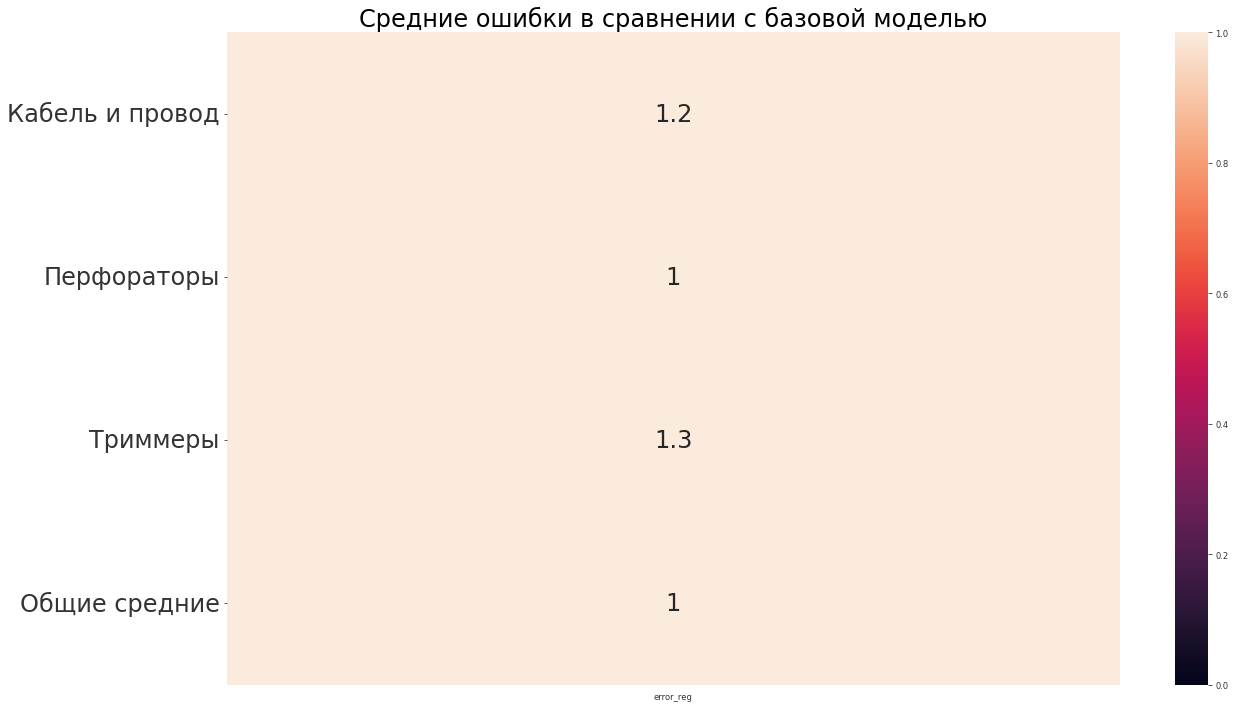

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.200000,0.238473
Перфораторы,0.250000,0.249696
Триммеры,0.059532,0.075538
Общие средние,0.153846,0.160626


------------------------------------------------------------------------

Forecasting 3 weeks after 2020-11-29


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157]
Error min is 0.05264570216906262


Tuning on rubric:  33%|███▎      | 1/3 [00:56<01:52, 56.27s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53]
Use covariates is True
Best covariate lag is [0, -1]
Error min is 0.007007863487033028


Tuning on rubric:  67%|██████▋   | 2/3 [01:44<00:51, 51.76s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -103, -104, -105, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53, -155, -156, -157]
Error min is 0.04635501048397948


Tuning on rubric: 100%|██████████| 3/3 [02:31<00:00, 50.35s/it]


2.5178855975468952


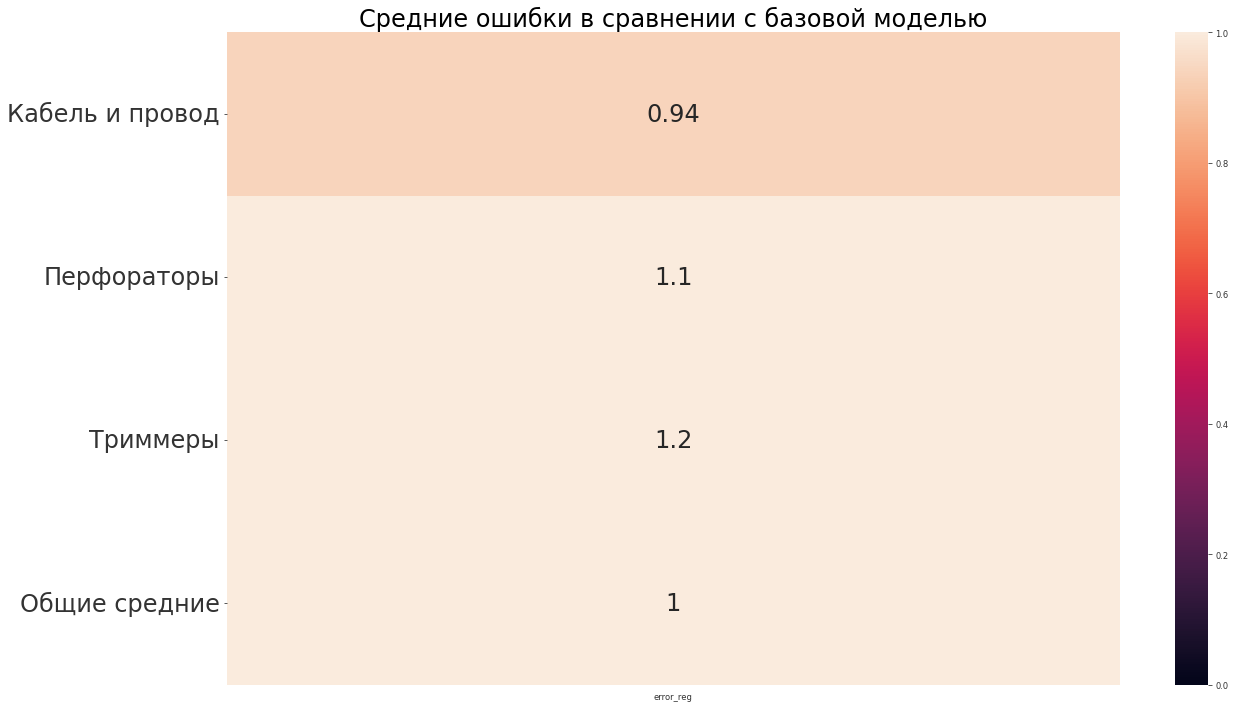

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.303846,0.285266
Перфораторы,0.230357,0.254986
Триммеры,0.076923,0.092844
Общие средние,0.175325,0.177287


------------------------------------------------------------------------

Forecasting 3 weeks after 2020-12-27


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157]
Use covariates is True
Best covariate lag is [0]
Error min is 0.07150002530357233


Tuning on rubric:  33%|███▎      | 1/3 [00:56<01:52, 56.35s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53]
Error min is 0.013803443995422018


Tuning on rubric:  67%|██████▋   | 2/3 [01:45<00:51, 51.98s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105]
Use covariates is True
Best covariate lag is [0, -1]
Error min is 0.05169837426422824


Tuning on rubric: 100%|██████████| 3/3 [02:29<00:00, 49.83s/it]


2.4914618651072185


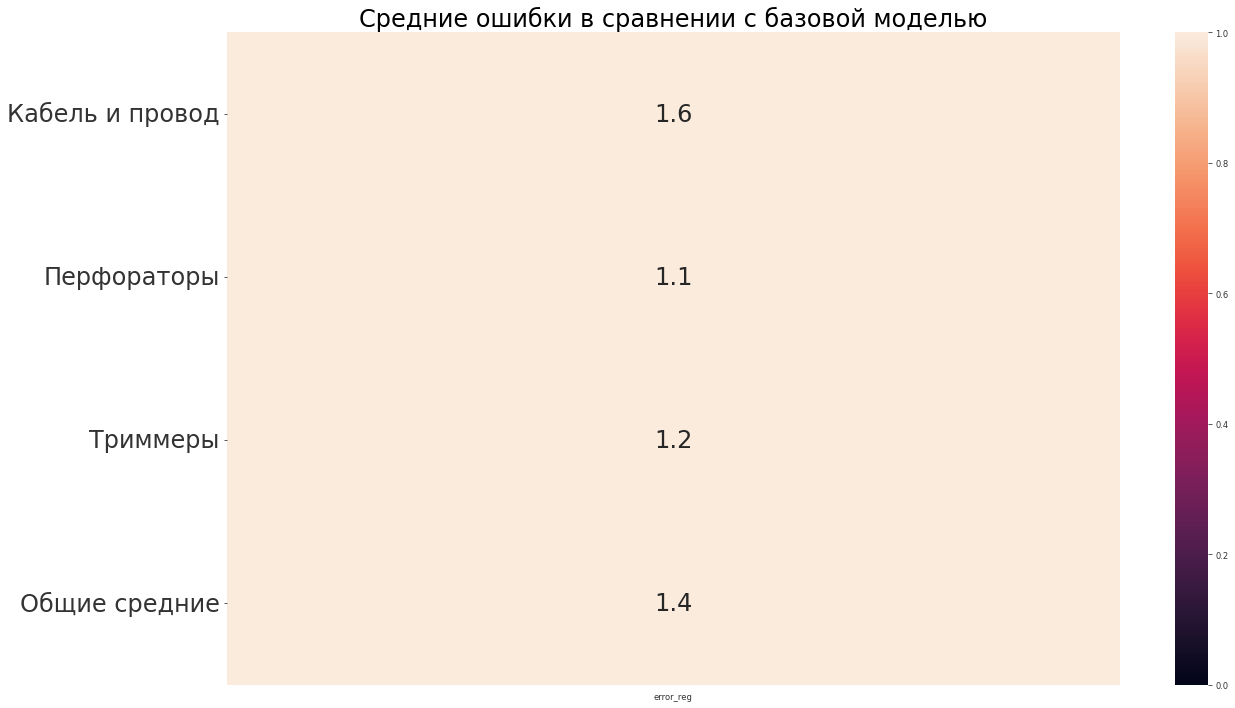

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.142857,0.230803
Перфораторы,0.285714,0.300639
Триммеры,0.052632,0.061066
Общие средние,0.150000,0.209969


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-01-24


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53]
Error min is 0.0575448463544568


Tuning on rubric:  33%|███▎      | 1/3 [00:54<01:49, 54.97s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53]
Use covariates is False
Error min is 0.009364708050484798


Tuning on rubric:  67%|██████▋   | 2/3 [01:41<00:49, 49.99s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3]
Use covariates is True
Best covariate lag is [0, -1, -2]
Error min is 0.03940271671610955


Tuning on rubric: 100%|██████████| 3/3 [02:24<00:00, 48.18s/it]


2.4091458360354108


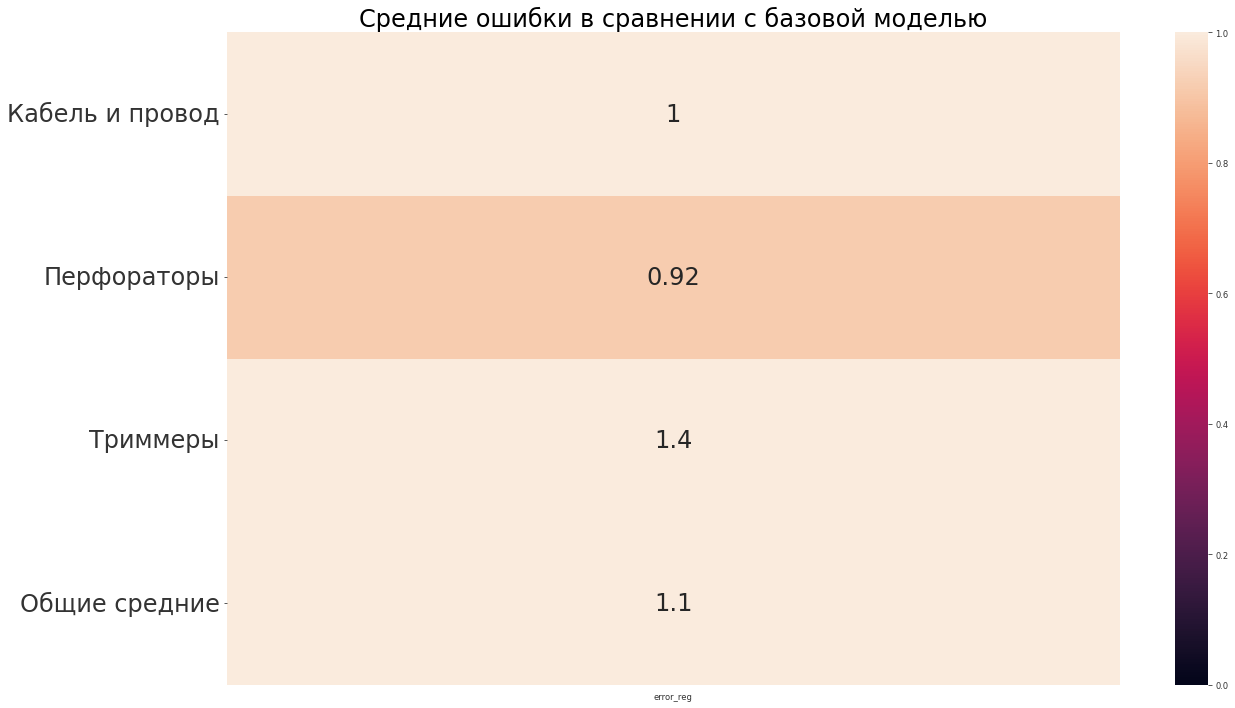

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.250000,0.262124
Перфораторы,0.285714,0.261516
Триммеры,0.047619,0.068569
Общие средние,0.157895,0.168040


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-02-21


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53]
Error min is 0.08151148173124957


Tuning on rubric:  33%|███▎      | 1/3 [00:57<01:55, 57.76s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0]
Error min is 0.004689832725766964


Tuning on rubric:  67%|██████▋   | 2/3 [01:46<00:52, 52.32s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -51, -52, -53]
Use covariates is False
Error min is 0.09359554872847616


Tuning on rubric: 100%|██████████| 3/3 [02:35<00:00, 51.92s/it]


2.5964861234029133


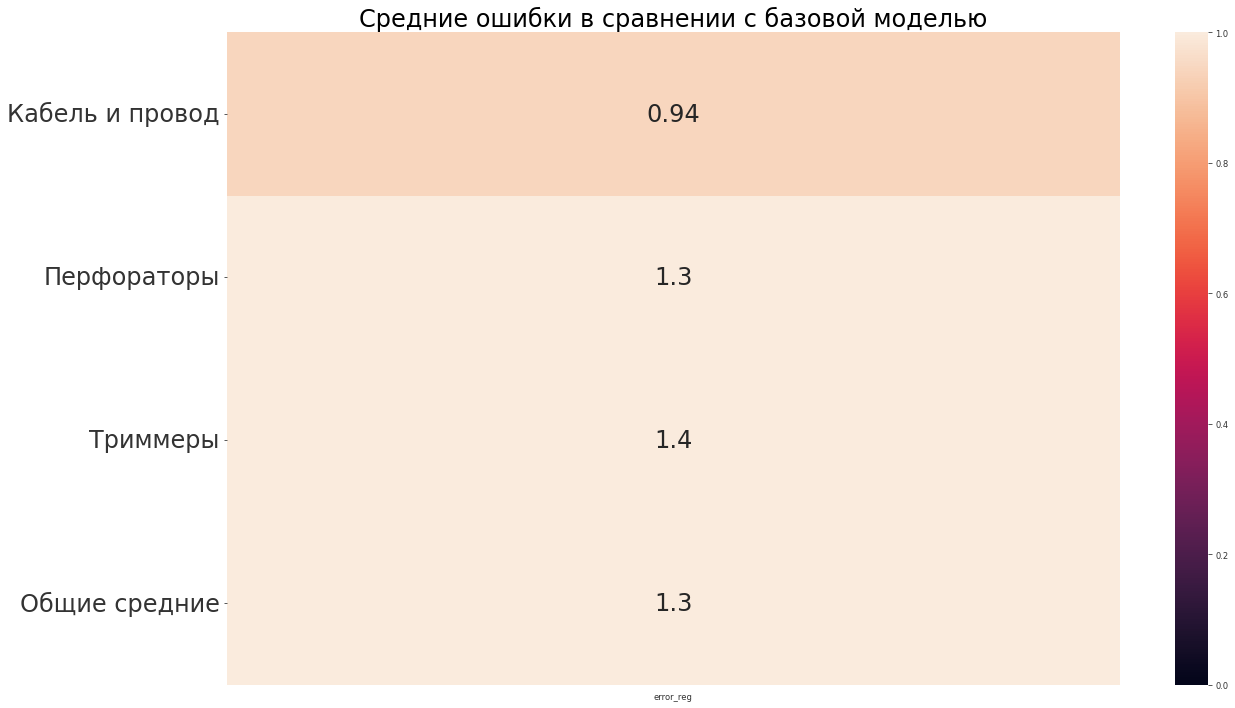

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.2500,0.236146
Перфораторы,0.2500,0.333947
Триммеры,0.0735,0.100098
Общие средние,0.1875,0.237241


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-03-21


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is False
Error min is 0.0815823246059205


Tuning on rubric:  33%|███▎      | 1/3 [00:58<01:57, 58.96s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157]
Use covariates is False
Error min is 0.007771062216685035


Tuning on rubric:  67%|██████▋   | 2/3 [01:50<00:54, 54.74s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2]
Use covariates is True
Best covariate lag is [0]
Error min is 0.08044352210118082


Tuning on rubric: 100%|██████████| 3/3 [02:39<00:00, 53.06s/it]


2.653589363892873


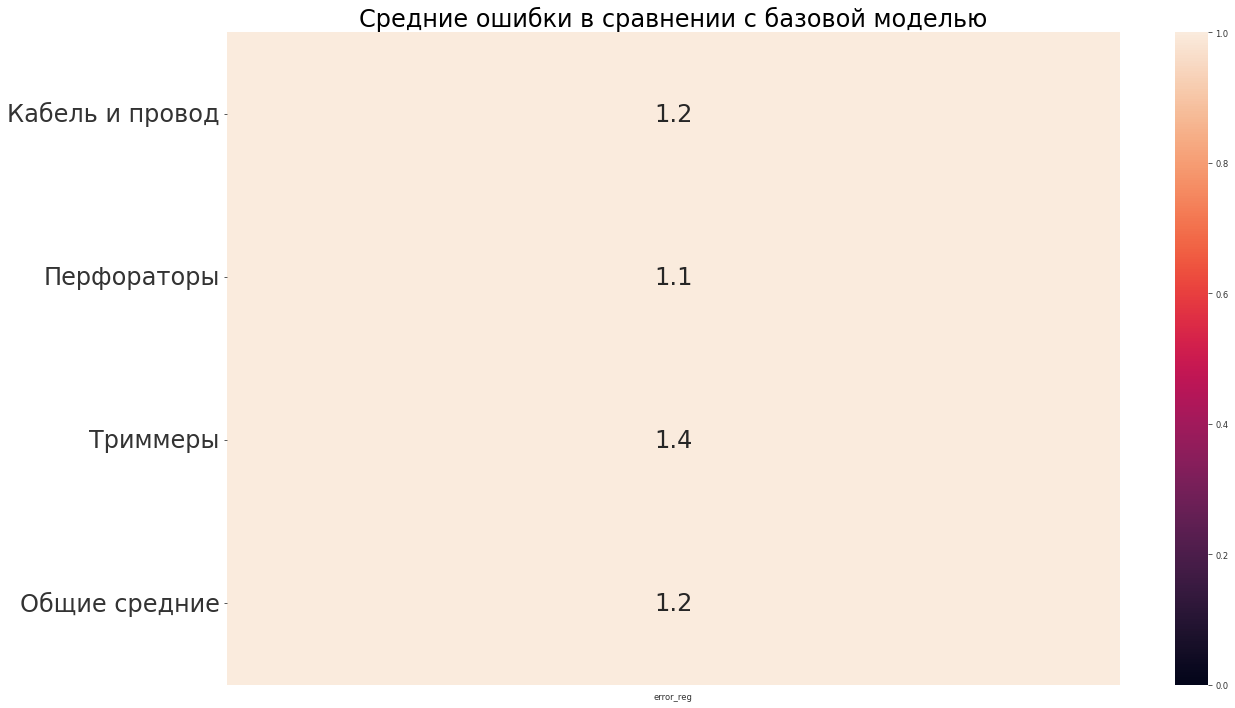

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.240000,0.289687
Перфораторы,0.200000,0.228748
Триммеры,0.083333,0.120571
Общие средние,0.166667,0.197428


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-04-18


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -103, -104, -105, -155, -156, -157]
Error min is 0.05443286669941548


Tuning on rubric:  33%|███▎      | 1/3 [00:57<01:54, 57.02s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -103, -104, -105, -155, -156, -157]
Error min is 0.00991903470789954


Tuning on rubric:  67%|██████▋   | 2/3 [01:51<00:55, 55.53s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -51, -52, -53]
Use covariates is False
Error min is 0.06255408952460013


Tuning on rubric: 100%|██████████| 3/3 [02:40<00:00, 53.48s/it]


2.6741242249806723


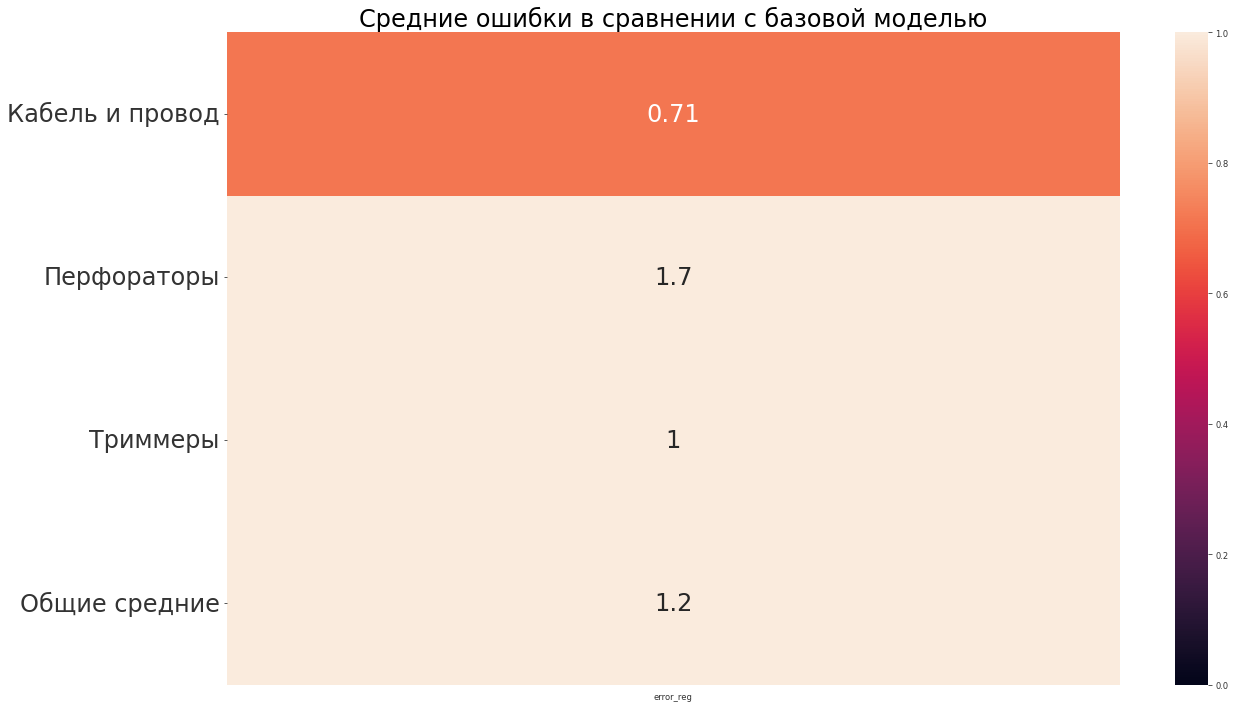

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.428571,0.305422
Перфораторы,0.166667,0.280259
Триммеры,0.153846,0.155698
Общие средние,0.192928,0.232507


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-05-16


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -103, -104, -105, -155, -156, -157]
Error min is 0.053175628507832036


Tuning on rubric:  33%|███▎      | 1/3 [00:59<01:59, 59.98s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157]
Error min is 0.030635676239014056


Tuning on rubric:  67%|██████▋   | 2/3 [01:55<00:57, 57.22s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -103, -104, -105, -155, -156, -157]
Use covariates is False
Error min is 0.1087063824062503


Tuning on rubric: 100%|██████████| 3/3 [02:42<00:00, 54.05s/it]


2.7029443621635436


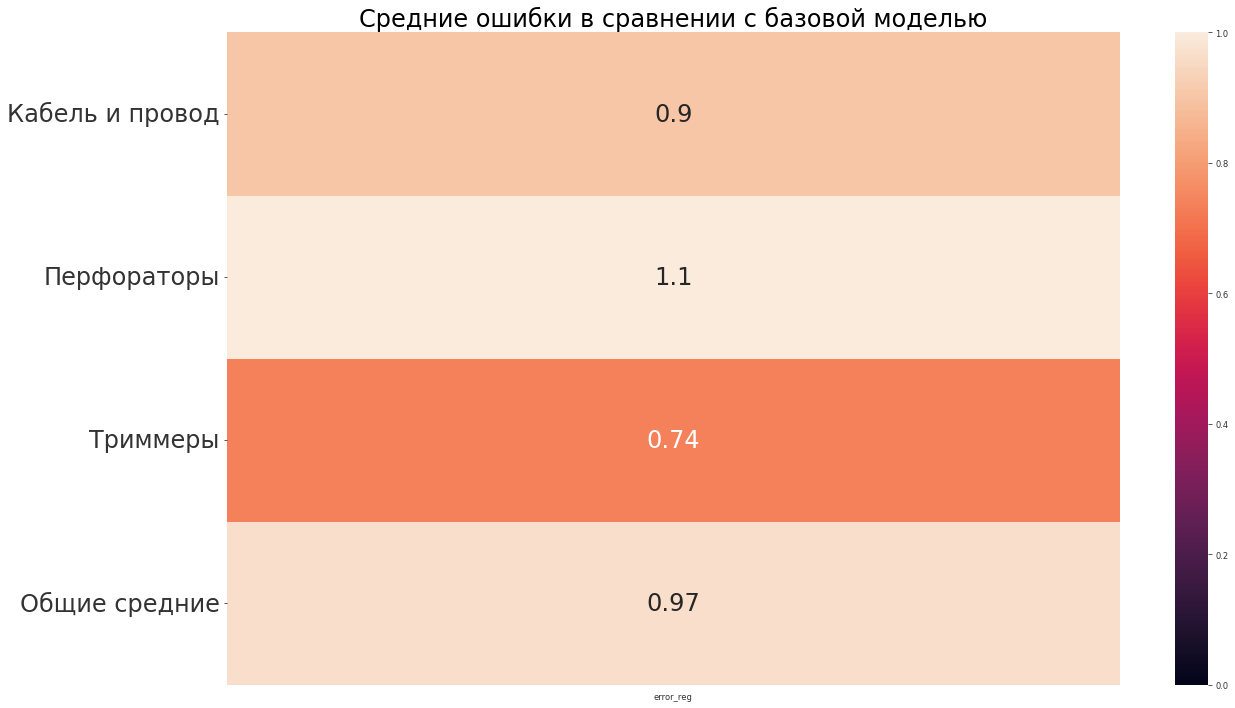

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.368421,0.331923
Перфораторы,0.250000,0.271834
Триммеры,0.884615,0.651285
Общие средние,0.397059,0.383558


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-06-13


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157]
Use covariates is True
Best covariate lag is [0]
Error min is 0.06587156449934968


Tuning on rubric:  33%|███▎      | 1/3 [00:59<01:59, 59.60s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53, -155, -156, -157]
Error min is 0.07492853336921637


Tuning on rubric:  67%|██████▋   | 2/3 [01:56<00:57, 57.75s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2]
Use covariates is True
Best covariate lag is [0]
Error min is 0.0813339509737704


Tuning on rubric: 100%|██████████| 3/3 [02:47<00:00, 55.88s/it]


2.794351859887441


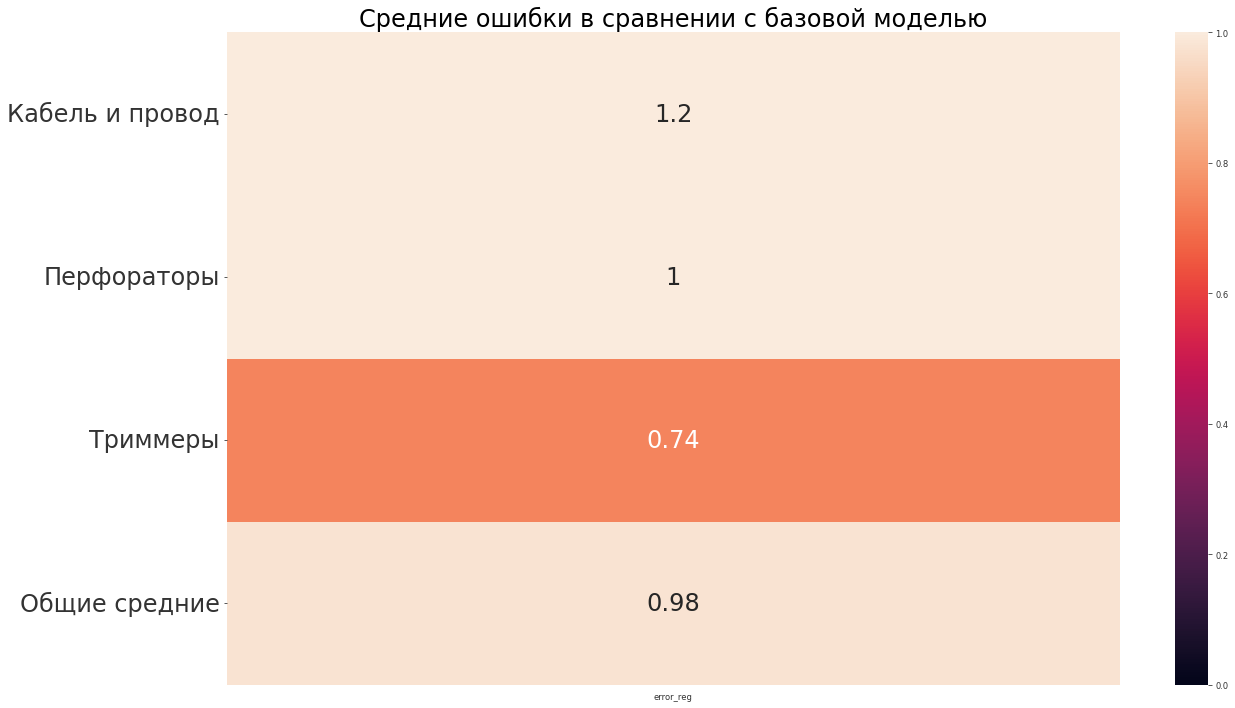

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.200000,0.248531
Перфораторы,0.234432,0.245253
Триммеры,0.473944,0.351761
Общие средние,0.285714,0.279767


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-07-11


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -51, -52, -53]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53, -155, -156, -157]
Error min is 0.06081813733012074


Tuning on rubric:  33%|███▎      | 1/3 [01:01<02:03, 61.93s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105, -155, -156, -157]
Use covariates is True
Best covariate lag is [0]
Error min is 0.09845552635550958


Tuning on rubric:  67%|██████▋   | 2/3 [02:02<01:01, 61.22s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1]
Error min is 0.05562259523905464


Tuning on rubric: 100%|██████████| 3/3 [02:55<00:00, 58.65s/it]


2.9327013929684957


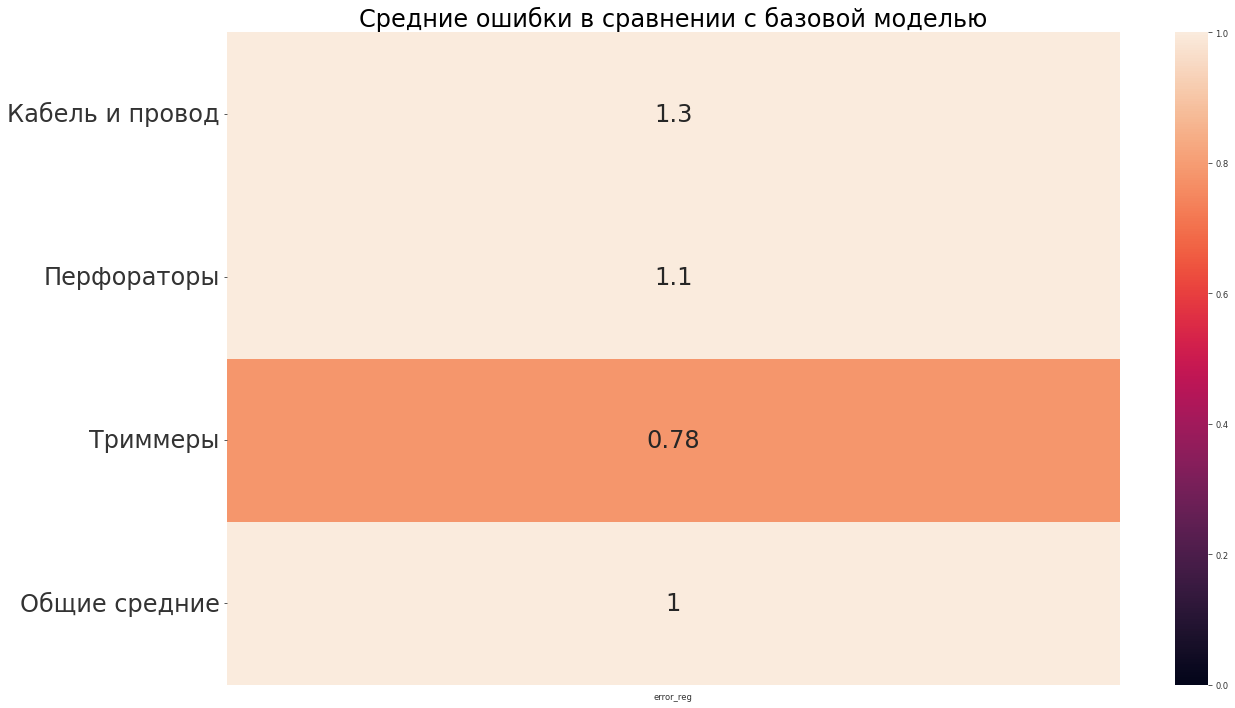

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.250000,0.317744
Перфораторы,0.243644,0.262075
Триммеры,0.272727,0.213897
Общие средние,0.250000,0.262075


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-08-08


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3, -103, -104, -105, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1, -2]
Error min is 0.049252092470203734


Tuning on rubric:  33%|███▎      | 1/3 [01:03<02:07, 63.59s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -103, -104, -105, -155, -156, -157]
Use covariates is True
Best covariate lag is [0]
Error min is 0.04319744411060982


Tuning on rubric:  67%|██████▋   | 2/3 [02:00<00:59, 59.43s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1]
Error min is 0.0753556999489413


Tuning on rubric: 100%|██████████| 3/3 [02:49<00:00, 56.42s/it]


2.8211541334788004


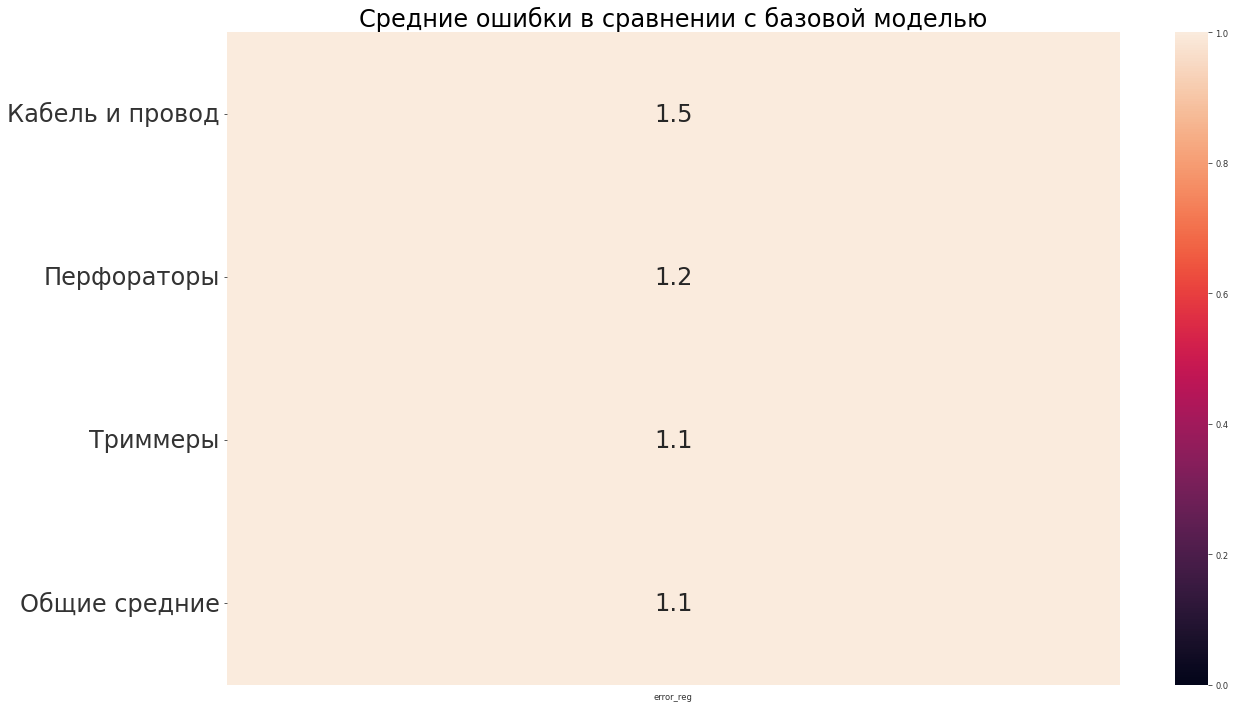

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.215251,0.328779
Перфораторы,0.200000,0.232276
Триммеры,0.127828,0.141329
Общие средние,0.176471,0.201636


------------------------------------------------------------------------

Forecasting 3 weeks after 2021-09-05


Tuning on rubric:   0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------------------------------------------

Rubric is Перфораторы
Best lag is [-1, -2, -3]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -103, -104, -105, -155, -156, -157]
Error min is 0.04275017907208874


Tuning on rubric:  33%|███▎      | 1/3 [00:58<01:57, 58.80s/it]

-----------------------------------------------------------------------

Rubric is Триммеры
Best lag is [-1, -2, -3, -51, -52, -53, -103, -104, -105]
Use covariates is True
Best covariate lag is [0, -1, -2, -3, -51, -52, -53, -103, -104, -105]
Error min is 0.02416163459205933


Tuning on rubric:  67%|██████▋   | 2/3 [01:57<00:58, 58.74s/it]

-----------------------------------------------------------------------

Rubric is Кабель и провод
Best lag is [-1, -2, -3, -51, -52, -53, -155, -156, -157]
Use covariates is True
Best covariate lag is [0, -1]
Error min is 0.03648940092612093


Tuning on rubric: 100%|██████████| 3/3 [02:47<00:00, 55.70s/it]


2.78518728017807


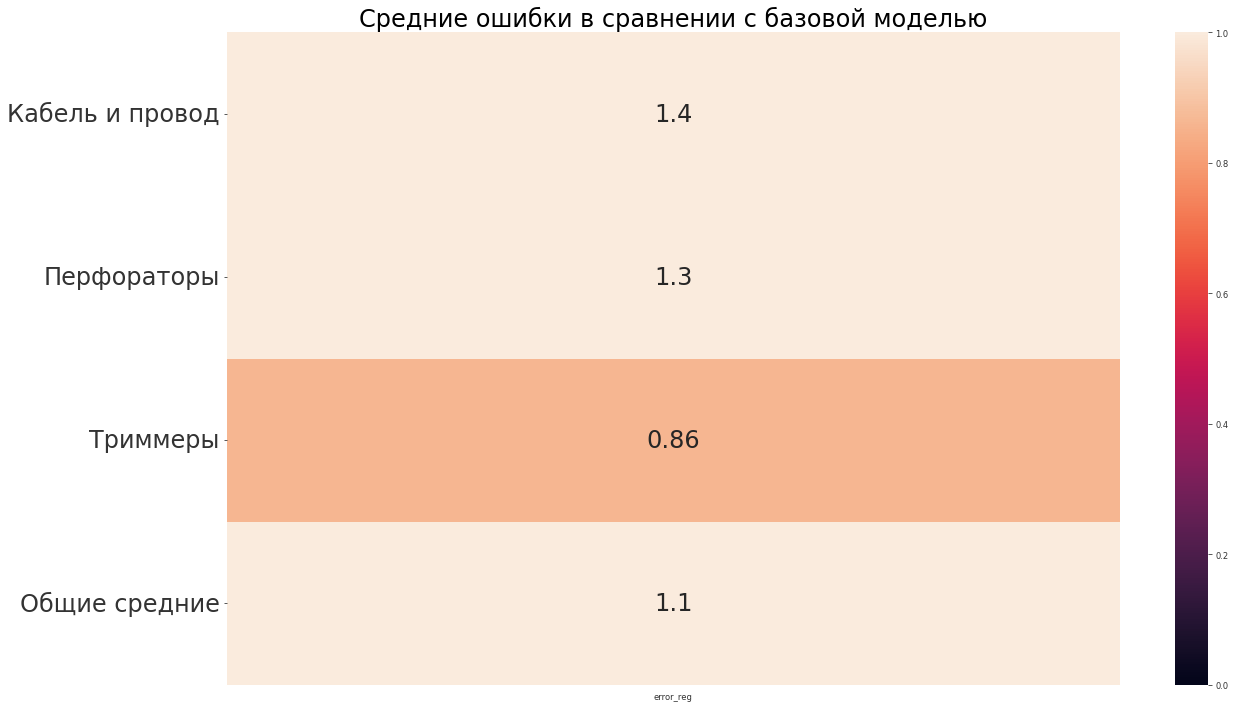

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.228571,0.316079
Перфораторы,0.191489,0.240730
Триммеры,0.142857,0.122809
Общие средние,0.175735,0.198031


------------------------------------------------------------------------



In [ ]:
date_start = '2020-10-04'
date = date_start
date_end = '2021-09-05'
stride = 4
while date <= date_end:
  print(f'Forecasting 3 weeks after {date}')
  display(tune_error_all(date))
  date = pd.Timestamp(date)
  date += timedelta(weeks=stride)
  date = datetime.strftime(date, "%Y-%m-%d")
  print('------------------------------------------------------------------------\n')
  

### No tune

In [ ]:
 
t = time()
error_frame_all = []
for rubric in tqdm(rubrics):
    art_rubric_ls = [art for art in art_sample if art in rubric_dict.query('rubr_lev1 == @rubric').index]
    ts_train_rubric = [ts_train_dict[art] for art in art_rubric_ls]
    covs_dict_rubric = [covs_dict[art] for art in art_rubric_ls]
    
    
    
    reg_model = RegressionModel(lags= [-157,-156,-155, -104,-103,-102,-51,-50,-49,-3, -2, -1],
                                #lags_past_covariates = [-3,-2,-1],
                               lags_future_covariates = [-157,-156,-155, -104,-103,-102,-51,-50,-49,-3,-2,-1,0])
    reg_model.fit(series=ts_train_rubric,
                  #past_covariates=list(covs_train_dict.values()),
                  future_covariates=covs_dict_rubric)
                  #val_series=ts_val_list,
                  #val_past_covariates=month_val_list)
    predict_reg = reg_model.predict(3, series = ts_train_rubric, future_covariates = covs_dict_rubric)   
    error_dict= {}
    for i, art in enumerate(art_rubric_ls):


        predict_base_sum = ts_train_dict[art][-3:].sum()
        predict_reg_sum = predict_reg[i].sum()
        actual_sum = ts_val_dict[art].sum()

        reg_error = abs(actual_sum - predict_reg_sum).iloc[0]

        base_error = abs(actual_sum - predict_base_sum).iloc[0]
        error_dict[art] = [reg_error, base_error]
        #ts_list[i].plot(label='actual')
        #predict_tft[i].plot()
        #print(tft_error/base_error)
        #plt.show()

    error_frame = pd.DataFrame.from_dict(error_dict, orient='index', columns=['error_reg', 'error_base'])
    error_frame_all.append(error_frame)              
                  
error_frame_all = pd.concat(error_frame_all)
error_frame_all = error_frame_all.reset_index().rename(columns={'index': 'articul'})


t = time() - t
print(t/60)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.31s/it]

0.4156458457310995


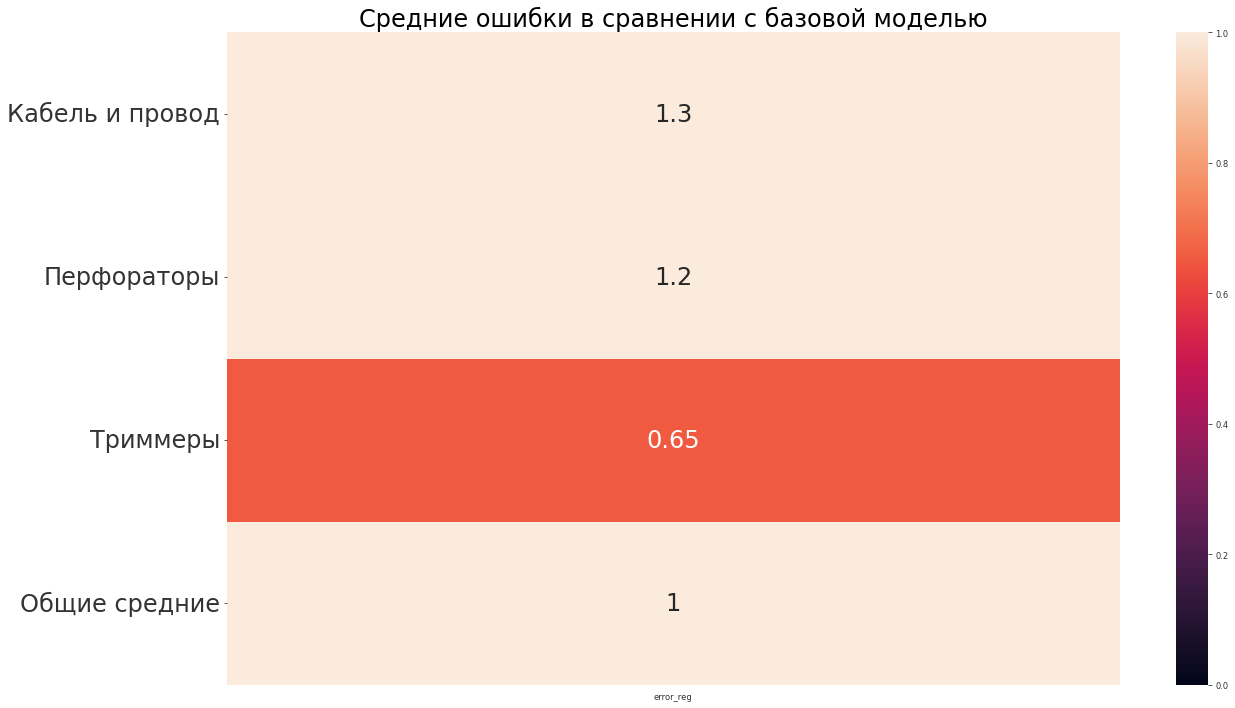

,error_base,error_reg
rubr_lev1,,
Кабель и провод,0.250000,0.327866
Перфораторы,0.250000,0.309038
Триммеры,0.148936,0.097358
Общие средние,0.200000,0.207933


In [ ]:
def base_scale_heatmap(df, df_for_means, show_means=True):
    df_base_scale = df.drop(['error_base'], axis=1).div(df['error_base'], axis=0)
    if show_means:
        means = df_for_means.abs().median()
        means = means / means['error_base']
        means = means.drop('error_base')
        means.name = 'Общие средние'
        df_base_scale = df_base_scale.append(means)
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.heatmap(df_base_scale, vmin=0, vmax=1, annot=True, annot_kws={"size": 24})
    plt.title('Средние ошибки в сравнении с базовой моделью', size=24)
    plt.ylabel('')
    plt.yticks(rotation=0, size=24)
    plt.xticks(None)
    plt.xlabel(None)
    plt.show() 
    return(df_base_scale)

def base_error_compare(error, category_list = ['rubr_lev1'], show_means=True, query=None):
    #base_error = base_error.merge(art_rubric_dict, on='articul')
    errors = pd.merge(rubric_dict, error, on='articul')
    if query:    
        errors = errors.query(query)
    #display(errors.sort_values(by='error_rbf', ascending=False).head(20))
    MAE_errors = errors.groupby(category_list).apply(lambda x : x[['error_base', 'error_reg']].abs().median())

    base_scale_heatmap(MAE_errors, errors[['error_base', 'error_reg']], show_means=show_means)
    
    

    return (MAE_errors.append(errors[['error_base', 'error_reg']].abs().median().rename('Общие средние')))


base_error_compare(error_frame_all, query=None)
